In [1]:
strategy_name = '培宏量化1号'

In [56]:
%load_ext line_profiler
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\web\dataServer")
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
from funcs import *
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

with open(r"d:\pkl\dailyBarMtx.pkl", 'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
dtes = np.array(dtes).astype(np.int)
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx']
high_mtx = z['high_mtx']
low_mtx = z['low_mtx']
close_mtx = z['close_mtx']

k = close_mtx==0
close_mtx = zero2pre(close_mtx)
open_mtx[k]=close_mtx[k]
high_mtx[k]=close_mtx[k]
low_mtx[k]=close_mtx[k]

name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
vol_mtx = z['vol_mtx']
amount_mtx = z['amount_mtx']


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [57]:
maxD = 4

In [58]:
dd = list(dbt.minuteBarStock.find({'ticker':'SH601988', 'dateAsInt':{'$gte':int(20200106), '$lte':int(20200109)}}, {'dateTime':1}))
timeAsFloat = []
for x in dd:
    l  = str(x['dateTime']+datetime.timedelta(hours=8))
    dl = float(l[0:4]+l[5:7]+l[8:10]+'.'+l[11:13]+l[14:16]+l[17:19])
    timeAsFloat.append(dl)
timeAsFloat=np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
timeLabels = []
dayOff = []
for i in range(maxD):
    for x in timeAsFloat:
        s = str(int(x*1e4))
        if len(s)<4:
            s='0'+s
        timeLabels.append('第'+str(i+1)+'天'+s[:2]+':'+s[2:4])
        dayOff.append(i)
timeAsFloat = list(timeAsFloat)*maxD
t = np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
maxM = t.shape[0] * maxD

In [59]:
trades = list(db.strategyBackTestTrades.find({'strategy_name':strategy_name}))
tradesUsed = []
Po = []
Ph = []
Pl = []
Pc = []
for (i,x) in enumerate(trades):
    #if (x['name'] in list(name)):
    p = list(name).index(x['name'])
    ticker = tkrs[p]
    d0 = x['dateIn']
    q = list(dtes).index(d0)
    j = np.min((q+maxD, dtes.shape[0]-1))
    d1 = dtes[j]
    dd = list(dbt.minuteBarStock.find({'ticker':ticker, 'dateAsInt':{'$gte':int(d0), '$lt':int(d1)}}, {'open':1, 'high':1, 'low':1,'close':1, 'dateTime':1}).sort([('dateTime',1)]))
    if dd==[]:
        continue
    tradesUsed.append(x)
    q = np.array([x['open'] for x in dd])
    print(i, '/', len(trades),len(q),dd[0]['dateTime'],dd[-1]['dateTime'])
    z = np.min((len(q),maxM))
    m = np.zeros(maxM)
    m[:z] = q[:z]
    m[z:] = m[z-1]
    Po.append(m)
    #q = np.array([x['high'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Ph.append(m)
    #q = np.array([x['low'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pl.append(m)
    #q = np.array([x['close'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pc.append(m)
Po = np.array(Po)
#Ph = np.array(Ph)
#Pl = np.array(Pl)
#Pc = np.array(Pc)

0 / 2958 960 2018-01-03 01:31:00 2018-01-08 07:00:00
1 / 2958 960 2018-01-03 01:31:00 2018-01-08 07:00:00
2 / 2958 960 2018-01-03 01:31:00 2018-01-08 07:00:00
3 / 2958 960 2018-01-03 01:31:00 2018-01-08 07:00:00
4 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
5 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
6 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
7 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
8 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
9 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
10 / 2958 960 2018-01-04 01:31:00 2018-01-09 07:00:00
11 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
12 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
13 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
14 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
15 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
16 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
17 / 2958 960 2018-01-05 01:31:00 2018-01-10 07:00:00
18 / 2958 960 2018-01-05 01:31:00 2018

153 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
154 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
155 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
156 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
157 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
158 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
159 / 2958 960 2018-02-27 01:31:00 2018-03-02 07:00:00
160 / 2958 960 2018-02-28 01:31:00 2018-03-05 07:00:00
161 / 2958 960 2018-02-28 01:31:00 2018-03-05 07:00:00
162 / 2958 960 2018-03-01 01:31:00 2018-03-06 07:00:00
163 / 2958 960 2018-03-01 01:31:00 2018-03-06 07:00:00
164 / 2958 960 2018-03-01 01:31:00 2018-03-06 07:00:00
165 / 2958 960 2018-03-01 01:31:00 2018-03-06 07:00:00
166 / 2958 960 2018-03-01 01:31:00 2018-03-06 07:00:00
167 / 2958 960 2018-03-02 01:31:00 2018-03-07 07:00:00
168 / 2958 960 2018-03-02 01:31:00 2018-03-07 07:00:00
169 / 2958 960 2018-03-02 01:31:00 2018-03-07 07:00:00
170 / 2958 960 2018-03-02 01:31:00 2018-03-07 07:00:00
171 / 2958

306 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
307 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
308 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
309 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
310 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
311 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
312 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
313 / 2958 960 2018-04-24 01:31:00 2018-04-27 07:00:00
314 / 2958 960 2018-04-25 01:31:00 2018-05-02 07:00:00
315 / 2958 960 2018-04-25 01:31:00 2018-05-02 07:00:00
316 / 2958 960 2018-04-25 01:31:00 2018-05-02 07:00:00
317 / 2958 960 2018-04-25 01:31:00 2018-05-02 07:00:00
318 / 2958 960 2018-04-25 01:31:00 2018-05-02 07:00:00
319 / 2958 960 2018-04-26 01:31:00 2018-05-03 07:00:00
320 / 2958 960 2018-04-26 01:31:00 2018-05-03 07:00:00
321 / 2958 960 2018-04-26 01:31:00 2018-05-03 07:00:00
322 / 2958 960 2018-04-26 01:31:00 2018-05-03 07:00:00
323 / 2958 960 2018-04-26 01:31:00 2018-05-03 07:00:00
324 / 2958

460 / 2958 960 2018-06-25 01:31:00 2018-06-28 07:00:00
461 / 2958 960 2018-06-25 01:31:00 2018-06-28 07:00:00
462 / 2958 960 2018-06-25 01:31:00 2018-06-28 07:00:00
463 / 2958 960 2018-06-25 01:31:00 2018-06-28 07:00:00
464 / 2958 960 2018-06-26 01:31:00 2018-06-29 07:00:00
465 / 2958 960 2018-06-26 01:31:00 2018-06-29 07:00:00
466 / 2958 960 2018-06-26 01:31:00 2018-06-29 07:00:00
467 / 2958 960 2018-06-27 01:31:00 2018-07-02 07:00:00
468 / 2958 960 2018-06-27 01:31:00 2018-07-02 07:00:00
469 / 2958 960 2018-06-27 01:31:00 2018-07-02 07:00:00
470 / 2958 960 2018-06-27 01:31:00 2018-07-02 07:00:00
471 / 2958 960 2018-06-28 01:31:00 2018-07-03 07:00:00
472 / 2958 960 2018-06-28 01:31:00 2018-07-03 07:00:00
473 / 2958 960 2018-06-28 01:31:00 2018-07-03 07:00:00
474 / 2958 960 2018-06-28 01:31:00 2018-07-03 07:00:00
475 / 2958 960 2018-06-29 01:31:00 2018-07-04 07:00:00
476 / 2958 960 2018-07-02 01:31:00 2018-07-05 07:00:00
477 / 2958 960 2018-07-02 01:31:00 2018-07-05 07:00:00
478 / 2958

613 / 2958 960 2018-08-17 01:31:00 2018-08-22 07:00:00
614 / 2958 960 2018-08-17 01:31:00 2018-08-22 07:00:00
615 / 2958 960 2018-08-17 01:31:00 2018-08-22 07:00:00
616 / 2958 960 2018-08-20 01:31:00 2018-08-23 07:00:00
617 / 2958 960 2018-08-21 01:31:00 2018-08-24 07:00:00
618 / 2958 960 2018-08-21 01:31:00 2018-08-24 07:00:00
619 / 2958 960 2018-08-21 01:31:00 2018-08-24 07:00:00
620 / 2958 960 2018-08-21 01:31:00 2018-08-24 07:00:00
621 / 2958 960 2018-08-21 01:31:00 2018-08-24 07:00:00
622 / 2958 960 2018-08-22 01:31:00 2018-08-27 07:00:00
623 / 2958 960 2018-08-22 01:31:00 2018-08-27 07:00:00
624 / 2958 960 2018-08-22 01:31:00 2018-08-27 07:00:00
625 / 2958 960 2018-08-22 01:31:00 2018-08-27 07:00:00
626 / 2958 960 2018-08-22 01:31:00 2018-08-27 07:00:00
627 / 2958 960 2018-08-23 01:31:00 2018-08-28 07:00:00
628 / 2958 960 2018-08-23 01:31:00 2018-08-28 07:00:00
629 / 2958 960 2018-08-23 01:31:00 2018-08-28 07:00:00
630 / 2958 960 2018-08-23 01:31:00 2018-08-28 07:00:00
631 / 2958

763 / 2958 960 2018-10-26 01:31:00 2018-10-31 07:00:00
764 / 2958 960 2018-10-26 01:31:00 2018-10-31 07:00:00
765 / 2958 960 2018-10-26 01:31:00 2018-10-31 07:00:00
766 / 2958 960 2018-10-29 01:31:00 2018-11-01 07:00:00
767 / 2958 960 2018-10-29 01:31:00 2018-11-01 07:00:00
768 / 2958 960 2018-10-29 01:31:00 2018-11-01 07:00:00
769 / 2958 960 2018-10-29 01:31:00 2018-11-01 07:00:00
770 / 2958 960 2018-10-30 01:31:00 2018-11-02 07:00:00
771 / 2958 960 2018-10-30 01:31:00 2018-11-02 07:00:00
772 / 2958 960 2018-10-31 01:31:00 2018-11-05 07:00:00
773 / 2958 960 2018-10-31 01:31:00 2018-11-05 07:00:00
774 / 2958 960 2018-10-31 01:31:00 2018-11-05 07:00:00
775 / 2958 960 2018-10-31 01:31:00 2018-11-05 07:00:00
776 / 2958 960 2018-10-31 01:31:00 2018-11-05 07:00:00
777 / 2958 960 2018-11-01 01:31:00 2018-11-06 07:00:00
778 / 2958 960 2018-11-01 01:31:00 2018-11-06 07:00:00
779 / 2958 960 2018-11-01 01:31:00 2018-11-06 07:00:00
780 / 2958 960 2018-11-01 01:31:00 2018-11-06 07:00:00
781 / 2958

912 / 2958 960 2018-12-05 01:31:00 2018-12-10 07:00:00
913 / 2958 960 2018-12-05 01:31:00 2018-12-10 07:00:00
914 / 2958 960 2018-12-06 01:31:00 2018-12-11 07:00:00
915 / 2958 960 2018-12-06 01:31:00 2018-12-11 07:00:00
916 / 2958 960 2018-12-06 01:31:00 2018-12-11 07:00:00
917 / 2958 960 2018-12-10 01:31:00 2018-12-13 07:00:00
918 / 2958 960 2018-12-10 01:31:00 2018-12-13 07:00:00
919 / 2958 960 2018-12-10 01:31:00 2018-12-13 07:00:00
920 / 2958 960 2018-12-10 01:31:00 2018-12-13 07:00:00
921 / 2958 960 2018-12-11 01:31:00 2018-12-14 07:00:00
922 / 2958 960 2018-12-11 01:31:00 2018-12-14 07:00:00
923 / 2958 960 2018-12-11 01:31:00 2018-12-14 07:00:00
924 / 2958 960 2018-12-12 01:31:00 2018-12-17 07:00:00
925 / 2958 960 2018-12-12 01:31:00 2018-12-17 07:00:00
926 / 2958 960 2018-12-12 01:31:00 2018-12-17 07:00:00
927 / 2958 960 2018-12-12 01:31:00 2018-12-17 07:00:00
928 / 2958 960 2018-12-12 01:31:00 2018-12-17 07:00:00
929 / 2958 960 2018-12-12 01:31:00 2018-12-17 07:00:00
930 / 2958

1063 / 2958 960 2019-02-15 01:31:00 2019-02-20 07:00:00
1064 / 2958 960 2019-02-15 01:31:00 2019-02-20 07:00:00
1065 / 2958 960 2019-02-15 01:31:00 2019-02-20 07:00:00
1066 / 2958 960 2019-02-18 01:31:00 2019-02-21 07:00:00
1067 / 2958 960 2019-02-18 01:31:00 2019-02-21 07:00:00
1068 / 2958 960 2019-02-18 01:31:00 2019-02-21 07:00:00
1069 / 2958 960 2019-02-18 01:31:00 2019-02-21 07:00:00
1070 / 2958 960 2019-02-18 01:31:00 2019-02-21 07:00:00
1071 / 2958 960 2019-02-19 01:31:00 2019-02-22 07:00:00
1072 / 2958 960 2019-02-19 01:31:00 2019-02-22 07:00:00
1073 / 2958 960 2019-02-19 01:31:00 2019-02-22 07:00:00
1074 / 2958 960 2019-02-19 01:31:00 2019-02-22 07:00:00
1075 / 2958 960 2019-02-19 01:31:00 2019-02-22 07:00:00
1076 / 2958 960 2019-02-20 01:31:00 2019-02-25 07:00:00
1077 / 2958 960 2019-02-20 01:31:00 2019-02-25 07:00:00
1078 / 2958 960 2019-02-20 01:31:00 2019-02-25 07:00:00
1079 / 2958 960 2019-02-21 01:31:00 2019-02-26 07:00:00
1080 / 2958 960 2019-02-21 01:31:00 2019-02-26 0

1213 / 2958 960 2019-03-25 01:31:00 2019-03-28 07:00:00
1214 / 2958 960 2019-03-25 01:31:00 2019-03-28 07:00:00
1215 / 2958 960 2019-03-25 01:31:00 2019-03-28 07:00:00
1216 / 2958 960 2019-03-25 01:31:00 2019-03-28 07:00:00
1217 / 2958 960 2019-03-25 01:31:00 2019-03-28 07:00:00
1218 / 2958 960 2019-03-25 01:31:00 2019-03-28 07:00:00
1219 / 2958 960 2019-03-26 01:31:00 2019-03-29 07:00:00
1220 / 2958 960 2019-03-26 01:31:00 2019-03-29 07:00:00
1221 / 2958 960 2019-03-26 01:31:00 2019-03-29 07:00:00
1222 / 2958 960 2019-03-26 01:31:00 2019-03-29 07:00:00
1223 / 2958 960 2019-03-26 01:31:00 2019-03-29 07:00:00
1224 / 2958 960 2019-03-27 01:31:00 2019-04-01 07:00:00
1225 / 2958 960 2019-03-27 01:31:00 2019-04-01 07:00:00
1226 / 2958 960 2019-03-27 01:31:00 2019-04-01 07:00:00
1227 / 2958 960 2019-03-27 01:31:00 2019-04-01 07:00:00
1228 / 2958 960 2019-03-27 01:31:00 2019-04-01 07:00:00
1229 / 2958 960 2019-03-27 01:31:00 2019-04-01 07:00:00
1230 / 2958 960 2019-03-28 01:31:00 2019-04-02 0

1364 / 2958 960 2019-05-06 01:31:00 2019-05-09 07:00:00
1365 / 2958 960 2019-05-07 01:31:00 2019-05-10 07:00:00
1366 / 2958 960 2019-05-08 01:31:00 2019-05-13 07:00:00
1367 / 2958 960 2019-05-08 01:31:00 2019-05-13 07:00:00
1368 / 2958 960 2019-05-08 01:31:00 2019-05-13 07:00:00
1369 / 2958 960 2019-05-08 01:31:00 2019-05-13 07:00:00
1370 / 2958 960 2019-05-08 01:31:00 2019-05-13 07:00:00
1371 / 2958 960 2019-05-08 01:31:00 2019-05-13 07:00:00
1372 / 2958 960 2019-05-09 01:31:00 2019-05-14 07:00:00
1373 / 2958 960 2019-05-09 01:31:00 2019-05-14 07:00:00
1374 / 2958 960 2019-05-09 01:31:00 2019-05-14 07:00:00
1375 / 2958 960 2019-05-09 01:31:00 2019-05-14 07:00:00
1376 / 2958 960 2019-05-09 01:31:00 2019-05-14 07:00:00
1377 / 2958 960 2019-05-09 01:31:00 2019-05-14 07:00:00
1378 / 2958 960 2019-05-10 01:31:00 2019-05-15 07:00:00
1379 / 2958 960 2019-05-10 01:31:00 2019-05-15 07:00:00
1380 / 2958 960 2019-05-10 01:31:00 2019-05-15 07:00:00
1381 / 2958 960 2019-05-13 01:31:00 2019-05-16 0

1514 / 2958 960 2019-06-20 01:31:00 2019-06-25 07:00:00
1515 / 2958 960 2019-06-21 01:31:00 2019-06-26 07:00:00
1516 / 2958 960 2019-06-21 01:31:00 2019-06-26 07:00:00
1517 / 2958 960 2019-06-21 01:31:00 2019-06-26 07:00:00
1518 / 2958 720 2019-06-21 01:31:00 2019-06-26 07:00:00
1519 / 2958 960 2019-06-21 01:31:00 2019-06-26 07:00:00
1520 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1521 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1522 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1523 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1524 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1525 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1526 / 2958 960 2019-06-24 01:31:00 2019-06-27 07:00:00
1527 / 2958 960 2019-06-25 01:31:00 2019-06-28 07:00:00
1528 / 2958 960 2019-06-25 01:31:00 2019-06-28 07:00:00
1529 / 2958 960 2019-06-25 01:31:00 2019-06-28 07:00:00
1530 / 2958 960 2019-06-25 01:31:00 2019-06-28 07:00:00
1531 / 2958 960 2019-06-25 01:31:00 2019-06-28 0

1661 / 2958 960 2019-08-15 01:31:00 2019-08-20 07:00:00
1662 / 2958 960 2019-08-15 01:31:00 2019-08-20 07:00:00
1663 / 2958 960 2019-08-15 01:31:00 2019-08-20 07:00:00
1664 / 2958 960 2019-08-15 01:31:00 2019-08-20 07:00:00
1665 / 2958 960 2019-08-16 01:31:00 2019-08-21 07:00:00
1666 / 2958 960 2019-08-16 01:31:00 2019-08-21 07:00:00
1667 / 2958 960 2019-08-16 01:31:00 2019-08-21 07:00:00
1668 / 2958 960 2019-08-16 01:31:00 2019-08-21 07:00:00
1669 / 2958 960 2019-08-16 01:31:00 2019-08-21 07:00:00
1670 / 2958 960 2019-08-16 01:31:00 2019-08-21 07:00:00
1671 / 2958 960 2019-08-19 01:31:00 2019-08-22 07:00:00
1672 / 2958 960 2019-08-19 01:31:00 2019-08-22 07:00:00
1673 / 2958 960 2019-08-19 01:31:00 2019-08-22 07:00:00
1674 / 2958 960 2019-08-19 01:31:00 2019-08-22 07:00:00
1675 / 2958 960 2019-08-20 01:31:00 2019-08-23 07:00:00
1676 / 2958 960 2019-08-20 01:31:00 2019-08-23 07:00:00
1677 / 2958 960 2019-08-20 01:31:00 2019-08-23 07:00:00
1678 / 2958 960 2019-08-20 01:31:00 2019-08-23 0

1957 / 2958 960 2019-12-05 01:31:00 2019-12-10 07:00:00
1958 / 2958 960 2019-12-06 01:31:00 2019-12-11 07:00:00
1959 / 2958 960 2019-12-06 01:31:00 2019-12-11 07:00:00
1960 / 2958 960 2019-12-06 01:31:00 2019-12-11 07:00:00
1961 / 2958 960 2019-12-06 01:31:00 2019-12-11 07:00:00
1962 / 2958 960 2019-12-06 01:31:00 2019-12-11 07:00:00
1963 / 2958 960 2019-12-06 01:31:00 2019-12-11 07:00:00
1964 / 2958 960 2019-12-09 01:31:00 2019-12-12 07:00:00
1965 / 2958 960 2019-12-09 01:31:00 2019-12-12 07:00:00
1966 / 2958 960 2019-12-09 01:31:00 2019-12-12 07:00:00
1967 / 2958 960 2019-12-09 01:31:00 2019-12-12 07:00:00
1968 / 2958 960 2019-12-09 01:31:00 2019-12-12 07:00:00
1969 / 2958 960 2019-12-09 01:31:00 2019-12-12 07:00:00
1970 / 2958 960 2019-12-10 01:31:00 2019-12-13 07:00:00
1971 / 2958 960 2019-12-10 01:31:00 2019-12-13 07:00:00
1972 / 2958 960 2019-12-11 01:31:00 2019-12-16 07:00:00
1973 / 2958 960 2019-12-11 01:31:00 2019-12-16 07:00:00
1974 / 2958 960 2019-12-11 01:31:00 2019-12-16 0

2106 / 2958 960 2020-01-14 01:31:00 2020-01-17 07:00:00
2107 / 2958 960 2020-01-14 01:31:00 2020-01-17 07:00:00
2108 / 2958 960 2020-01-14 01:31:00 2020-01-17 07:00:00
2109 / 2958 960 2020-01-14 01:31:00 2020-01-17 07:00:00
2110 / 2958 960 2020-01-15 01:31:00 2020-01-20 07:00:00
2111 / 2958 960 2020-01-15 01:31:00 2020-01-20 07:00:00
2112 / 2958 960 2020-01-15 01:31:00 2020-01-20 07:00:00
2113 / 2958 960 2020-01-16 01:31:00 2020-01-21 07:00:00
2114 / 2958 960 2020-01-16 01:31:00 2020-01-21 07:00:00
2115 / 2958 960 2020-01-16 01:31:00 2020-01-21 07:00:00
2116 / 2958 960 2020-01-17 01:31:00 2020-01-22 07:00:00
2117 / 2958 960 2020-01-17 01:31:00 2020-01-22 07:00:00
2118 / 2958 960 2020-01-20 01:31:00 2020-01-23 07:00:00
2119 / 2958 960 2020-01-20 01:31:00 2020-01-23 07:00:00
2120 / 2958 960 2020-01-20 01:31:00 2020-01-23 07:00:00
2121 / 2958 960 2020-01-20 01:31:00 2020-01-23 07:00:00
2122 / 2958 960 2020-01-20 01:31:00 2020-01-23 07:00:00
2123 / 2958 960 2020-01-20 01:31:00 2020-01-23 0

2254 / 2958 960 2020-03-05 01:31:00 2020-03-10 07:00:00
2255 / 2958 960 2020-03-05 01:31:00 2020-03-10 07:00:00
2256 / 2958 960 2020-03-05 01:31:00 2020-03-10 07:00:00
2257 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2258 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2259 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2260 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2261 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2262 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2263 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2264 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2265 / 2958 960 2020-03-06 01:31:00 2020-03-11 07:00:00
2266 / 2958 960 2020-03-09 01:31:00 2020-03-12 07:00:00
2267 / 2958 960 2020-03-09 01:31:00 2020-03-12 07:00:00
2268 / 2958 960 2020-03-09 01:31:00 2020-03-12 07:00:00
2269 / 2958 960 2020-03-09 01:31:00 2020-03-12 07:00:00
2270 / 2958 960 2020-03-09 01:31:00 2020-03-12 07:00:00
2271 / 2958 960 2020-03-09 01:31:00 2020-03-12 0

2404 / 2958 960 2020-04-21 01:31:00 2020-04-24 07:00:00
2405 / 2958 960 2020-04-21 01:31:00 2020-04-24 07:00:00
2406 / 2958 960 2020-04-22 01:31:00 2020-04-27 07:00:00
2407 / 2958 960 2020-04-22 01:31:00 2020-04-27 07:00:00
2408 / 2958 960 2020-04-22 01:31:00 2020-04-27 07:00:00
2409 / 2958 960 2020-04-22 01:31:00 2020-04-27 07:00:00
2410 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2411 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2412 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2413 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2414 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2415 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2416 / 2958 960 2020-04-23 01:31:00 2020-04-28 07:00:00
2417 / 2958 960 2020-04-24 01:31:00 2020-04-29 07:00:00
2418 / 2958 960 2020-04-24 01:31:00 2020-04-29 07:00:00
2419 / 2958 960 2020-04-24 01:31:00 2020-04-29 07:00:00
2420 / 2958 960 2020-04-24 01:31:00 2020-04-29 07:00:00
2421 / 2958 960 2020-04-27 01:31:00 2020-04-30 0

2556 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2557 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2558 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2559 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2560 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2561 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2562 / 2958 960 2020-06-03 01:31:00 2020-06-08 07:00:00
2563 / 2958 960 2020-06-04 01:31:00 2020-06-09 07:00:00
2564 / 2958 960 2020-06-04 01:31:00 2020-06-09 07:00:00
2565 / 2958 960 2020-06-04 01:31:00 2020-06-09 07:00:00
2566 / 2958 960 2020-06-04 01:31:00 2020-06-09 07:00:00
2567 / 2958 960 2020-06-05 01:31:00 2020-06-10 07:00:00
2568 / 2958 960 2020-06-05 01:31:00 2020-06-10 07:00:00
2569 / 2958 960 2020-06-05 01:31:00 2020-06-10 07:00:00
2570 / 2958 960 2020-06-05 01:31:00 2020-06-10 07:00:00
2571 / 2958 960 2020-06-05 01:31:00 2020-06-10 07:00:00
2572 / 2958 960 2020-06-05 01:31:00 2020-06-10 07:00:00
2573 / 2958 960 2020-06-08 01:31:00 2020-06-11 0

2705 / 2958 960 2020-07-13 01:31:00 2020-07-16 07:00:00
2706 / 2958 960 2020-07-13 01:31:00 2020-07-16 07:00:00
2707 / 2958 960 2020-07-13 01:31:00 2020-07-16 07:00:00
2708 / 2958 960 2020-07-13 01:31:00 2020-07-16 07:00:00
2709 / 2958 960 2020-07-14 01:31:00 2020-07-17 07:00:00
2710 / 2958 960 2020-07-14 01:31:00 2020-07-17 07:00:00
2711 / 2958 960 2020-07-14 01:31:00 2020-07-17 07:00:00
2712 / 2958 960 2020-07-14 01:31:00 2020-07-17 07:00:00
2713 / 2958 960 2020-07-14 01:31:00 2020-07-17 07:00:00
2714 / 2958 960 2020-07-14 01:31:00 2020-07-17 07:00:00
2715 / 2958 960 2020-07-15 01:31:00 2020-07-20 07:00:00
2716 / 2958 960 2020-07-15 01:31:00 2020-07-20 07:00:00
2717 / 2958 960 2020-07-15 01:31:00 2020-07-20 07:00:00
2718 / 2958 960 2020-07-15 01:31:00 2020-07-20 07:00:00
2719 / 2958 960 2020-07-15 01:31:00 2020-07-20 07:00:00
2720 / 2958 960 2020-07-16 01:31:00 2020-07-21 07:00:00
2721 / 2958 960 2020-07-16 01:31:00 2020-07-21 07:00:00
2722 / 2958 960 2020-07-16 01:31:00 2020-07-21 0

2853 / 2958 960 2020-08-24 01:31:00 2020-08-27 07:00:00
2854 / 2958 960 2020-08-24 01:31:00 2020-08-27 07:00:00
2855 / 2958 960 2020-08-25 01:31:00 2020-08-28 07:00:00
2856 / 2958 960 2020-08-25 01:31:00 2020-08-28 07:00:00
2857 / 2958 960 2020-08-25 01:31:00 2020-08-28 07:00:00
2858 / 2958 960 2020-08-25 01:31:00 2020-08-28 07:00:00
2859 / 2958 960 2020-08-25 01:31:00 2020-08-28 07:00:00
2860 / 2958 960 2020-08-26 01:31:00 2020-08-31 07:00:00
2861 / 2958 960 2020-08-26 01:31:00 2020-08-31 07:00:00
2862 / 2958 960 2020-08-26 01:31:00 2020-08-31 07:00:00
2863 / 2958 960 2020-08-27 01:31:00 2020-09-01 07:00:00
2864 / 2958 960 2020-08-27 01:31:00 2020-09-01 07:00:00
2865 / 2958 960 2020-08-27 01:31:00 2020-09-01 07:00:00
2866 / 2958 960 2020-08-27 01:31:00 2020-09-01 07:00:00
2867 / 2958 960 2020-08-27 01:31:00 2020-09-01 07:00:00
2868 / 2958 960 2020-08-28 01:31:00 2020-09-02 07:00:00
2869 / 2958 960 2020-08-28 01:31:00 2020-09-02 07:00:00
2870 / 2958 960 2020-08-28 01:31:00 2020-09-02 0

In [60]:
#x = [str(x) for x in dateLabel]
#dateLabel
#dLabel = np.array([datetime.datetime.strptime(str(int(float(d)*1e4)), '%H%M').date() for d in x])

In [61]:
r=Po[:,1:]/Po[:,:-1] - 1
r=np.hstack((np.zeros((r.shape[0],1)),r))
priceChange = np.mean(r,axis=0)
priceChangeStd = np.std(r, axis=0)
priceChangeStd[np.isfinite(priceChangeStd)==False]=0

In [70]:
def drawPriceChange(r, title='平均价格随时间变化', tp=[5,400]):
    plt.rcParams['font.sans-serif'] = [u'SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    default_dpi = plt.rcParamsDefault['figure.dpi']
    plt.rcParams['figure.dpi'] = default_dpi*1.5
    priceChange = np.mean(r,axis=0)
    priceChangeStd = np.std(r, axis=0)
    priceChangeStd[np.isfinite(priceChangeStd)==False]=0
    plt.figure()
    plt.title(title)
    legends=[]
    if np.max(tp)<600:
        linewidth=1
    else:
        linewidth=0.25
    for k in tp:
        plt.plot([k, k],[-0.023,0.013], linewidth=linewidth)
        legends.append(timeLabels[k])
    plt.plot(np.cumsum(priceChange),'b-', marker="o", linewidth=0.25,markersize=0.25)
    plt.plot(priceChangeStd, 'k',  linewidth=0.25, markersize=0.25)
    legends.append('分钟价格回报率变化累积')
    legends.append('分钟价格回报率标准差')
    plt.legend(legends,bbox_to_anchor=(1.0, 1.0), loc=2, borderaxespad=0.)
    plt.grid()
    db.strategyMinuteBar.update_one({strategy_name:strategy_name, title:title}, {'$set':{
        'labels':timeLabels,
        'priceChange': list(priceChange),
        'priceChangeStd': list(priceChangeStd),
        'concernPoints': tp,
        'priceType': '开盘价'
    }},upsert=True)


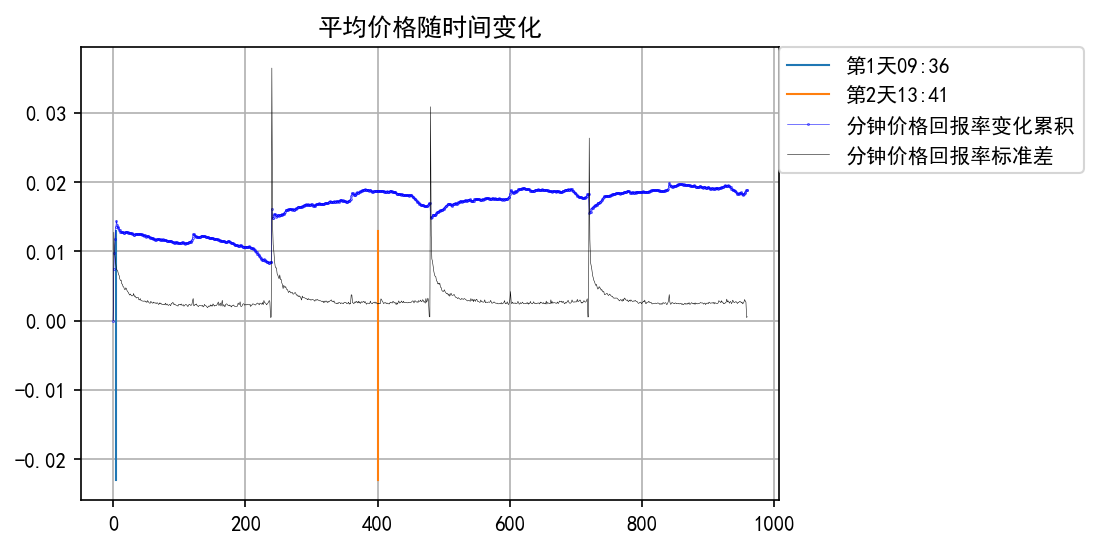

In [71]:
drawPriceChange(r)

In [72]:
inTime = 5
otTime = 400

In [73]:
def getPnl():
    dd = list(dtes)
    nn = list(name)
    pnl = []
    dtesPnl = []
    l = [x['dateIn'] for x in trades]
    c = {}
    for q in l:
        c[q]=l.count(q)
    for (i,t) in enumerate(trades):
        n = t['name']
        j = dd.index(t['dateIn'])
        jin = j + dayOff[inTime]
        jot = j + dayOff[otTime]
        if (jin>=len(dtes)):
            jin = len(dtes)-1
        if (jot>=len(dtes)):
            jot = len(dtes)-1
        din = dtes[jin]+timeAsFloat[inTime]
        dot = dtes[jot]+timeAsFloat[otTime]
        dtIn=datetime.datetime.strptime(str(din), '%Y%m%d.%H%M')+datetime.timedelta(hours=-8)
        dtOt=datetime.datetime.strptime(str(dot), '%Y%m%d.%H%M')+datetime.timedelta(hours=-8)
        q1 = dbt.minuteBarStock.find_one({'ticker':tkrs[nn.index(n)], 'dateTime':dtIn},{'ticker':1, 'name':1, 'close':1})
        q2 = dbt.minuteBarStock.find_one({'ticker':tkrs[nn.index(n)], 'dateTime':dtOt},{'ticker':1, 'name':1, 'close':1})
        if q1==None:
            continue
        if q2==None:
            continue
        r = q2['close']/q1['close']-1
        print(t['dateIn'], n, din, '价',q1['close'], dot,'价',q2['close'],'利润',np.round(r*1e4)/1e2,'%')
        pnl.append(r)
        dtesPnl.append(t['dateIn'])
    dq = []
    pq = []
    pnl = np.array(pnl)
    dtesPnl = np.array(dtesPnl)
    for x in sorted(set(dtesPnl)):
        dq.append(x)
        pq.append(np.mean(pnl[dtesPnl==x]))
    return dq,pq

In [74]:
# #%lprun -f getPnl getPnl()
dtesPnl,pnl = getPnl()

20180103 首创股份 20180103.0936 价 5.35 20180104.1341 价 5.79 利润 8.22 %
20180103 北新建材 20180103.0936 价 25.25 20180104.1341 价 25.41 利润 0.63 %
20180103 山东黄金 20180103.0936 价 32.12 20180104.1341 价 31.27 利润 -2.65 %
20180103 中远海控 20180103.0936 价 6.97 20180104.1341 价 7.07 利润 1.43 %
20180104 中房股份 20180104.0936 价 11.38 20180105.1341 价 11.61 利润 2.02 %
20180104 德赛电池 20180104.0936 价 41.69 20180105.1341 价 42.24 利润 1.32 %
20180104 常熟银行 20180104.0936 价 7.41 20180105.1341 价 7.87 利润 6.21 %
20180104 中国宝安 20180104.0936 价 7.63 20180105.1341 价 7.54 利润 -1.18 %
20180104 洲际油气 20180104.0936 价 4.55 20180105.1341 价 4.65 利润 2.2 %
20180104 新潮能源 20180104.0936 价 3.98 20180105.1341 价 3.97 利润 -0.25 %
20180104 重庆钢铁 20180104.0936 价 2.37 20180105.1341 价 2.49 利润 5.06 %
20180105 赢时胜 20180105.0936 价 13.08 20180108.1341 价 13.41 利润 2.52 %
20180105 暴风退 20180105.0936 价 24.33 20180108.1341 价 24.9 利润 2.34 %
20180105 重庆啤酒 20180105.0936 价 22.65 20180108.1341 价 21.85 利润 -3.53 %
20180105 燕京啤酒 20180105.0936 价 7.12 20180108.1341 价 7.11 利润 -0.

20180222 罗 牛 山 20180222.0936 价 7.81 20180223.1341 价 7.94 利润 1.66 %
20180222 北京文化 20180222.0936 价 11.84 20180223.1341 价 11.46 利润 -3.21 %
20180222 世茂股份 20180222.0936 价 5.32 20180223.1341 价 5.27 利润 -0.94 %
20180222 成飞集成 20180222.0936 价 22.8 20180223.1341 价 22.1 利润 -3.07 %
20180222 洛阳钼业 20180222.0936 价 7.3 20180223.1341 价 7.84 利润 7.4 %
20180223 银之杰 20180223.0936 价 12.8 20180226.1341 价 14.08 利润 10.0 %
20180223 *ST当代 20180223.0936 价 13.63 20180226.1341 价 14.95 利润 9.68 %
20180223 上海物贸 20180223.0936 价 12.53 20180226.1341 价 12.33 利润 -1.6 %
20180223 保变电气 20180223.0936 价 6.29 20180226.1341 价 6.24 利润 -0.79 %
20180223 创业环保 20180223.0936 价 11.68 20180226.1341 价 11.63 利润 -0.43 %
20180226 山鹰纸业 20180226.0936 价 5.27 20180227.1341 价 5.23 利润 -0.76 %
20180226 冠豪高新 20180226.0936 价 4.67 20180227.1341 价 4.72 利润 1.07 %
20180226 厦门象屿 20180226.0936 价 8.14 20180227.1341 价 8.23 利润 1.11 %
20180226 安阳钢铁 20180226.0936 价 5.32 20180227.1341 价 5.11 利润 -3.95 %
20180226 上海机场 20180226.0936 价 48.8 20180227.1341 价 49.49 利润 1

20180412 天茂集团 20180412.0936 价 8.05 20180413.1341 价 7.97 利润 -0.99 %
20180412 广电运通 20180412.0936 价 7.45 20180413.1341 价 7.71 利润 3.49 %
20180412 均胜电子 20180412.0936 价 30.05 20180413.1341 价 30.62 利润 1.9 %
20180413 思创医惠 20180413.0936 价 11.97 20180416.1341 价 11.85 利润 -1.0 %
20180413 卫宁健康 20180413.0936 价 12.6 20180416.1341 价 12.03 利润 -4.52 %
20180413 贝瑞基因 20180413.0936 价 60.85 20180416.1341 价 59.16 利润 -2.78 %
20180413 东华软件 20180413.0936 价 8.34 20180416.1341 价 8.37 利润 0.36 %
20180416 冠豪高新 20180416.0936 价 4.5 20180417.1341 价 4.22 利润 -6.22 %
20180416 东华软件 20180416.0936 价 8.5 20180417.1341 价 8.14 利润 -4.24 %
20180416 珠江实业 20180416.0936 价 6.97 20180417.1341 价 6.43 利润 -7.75 %
20180416 顺鑫农业 20180416.0936 价 25.94 20180417.1341 价 26.01 利润 0.27 %
20180417 罗 牛 山 20180417.0936 价 11.97 20180418.1341 价 10.08 利润 -15.79 %
20180417 中国长城 20180417.0936 价 9.6 20180418.1341 价 9.39 利润 -2.19 %
20180417 思创医惠 20180417.0936 价 12.84 20180418.1341 价 12.89 利润 0.39 %
20180417 节能风电 20180417.0936 价 3.09 20180418.1341 价 3.05 利

20180607 紫金矿业 20180607.0936 价 4.01 20180608.1341 价 3.95 利润 -1.5 %
20180607 华菱钢铁 20180607.0936 价 8.6 20180608.1341 价 8.54 利润 -0.7 %
20180607 申通快递 20180607.0936 价 23.98 20180608.1341 价 23.72 利润 -1.08 %
20180607 柳钢股份 20180607.0936 价 7.22 20180608.1341 价 7.11 利润 -1.52 %
20180608 中信国安 20180608.0936 价 6.49 20180611.1341 价 5.97 利润 -8.01 %
20180608 四川长虹 20180608.0936 价 3.34 20180611.1341 价 3.15 利润 -5.69 %
20180611 珠海中富 20180611.0936 价 3.01 20180612.1341 价 2.99 利润 -0.66 %
20180612 莱茵体育 20180612.0936 价 5.13 20180613.1341 价 5.21 利润 1.56 %
20180612 中粮科技 20180612.0936 价 10.46 20180613.1341 价 10.9 利润 4.21 %
20180612 远大智能 20180612.0936 价 4.05 20180613.1341 价 3.96 利润 -2.22 %
20180612 梦网集团 20180612.0936 价 10.08 20180613.1341 价 9.63 利润 -4.46 %
20180613 众信旅游 20180613.0936 价 11.66 20180614.1341 价 10.71 利润 -8.15 %
20180613 亿帆医药 20180613.0936 价 18.17 20180614.1341 价 18.3 利润 0.72 %
20180613 深粮控股 20180613.0936 价 11.97 20180614.1341 价 13.17 利润 10.03 %
20180613 黄河旋风 20180613.0936 价 4.97 20180614.1341 价 4.67 利润 

20180808 时代新材 20180808.0936 价 9.17 20180809.1341 价 9.17 利润 0.0 %
20180808 伊力特   20180808.0936 价 21.6 20180809.1341 价 21.05 利润 -2.55 %
20180808 佳都科技 20180808.0936 价 7.27 20180809.1341 价 7.23 利润 -0.55 %
20180809 梅花生物 20180809.0936 价 4.09 20180810.1341 价 4.01 利润 -1.96 %
20180809 焦作万方 20180809.0936 价 5.01 20180810.1341 价 4.83 利润 -3.59 %
20180809 *ST赫美 20180809.0936 价 10.02 20180810.1341 价 11.02 利润 9.98 %
20180810 万  科Ａ 20180810.0936 价 23.36 20180813.1341 价 22.88 利润 -2.05 %
20180810 物产中大 20180810.0936 价 5.43 20180813.1341 价 5.19 利润 -4.42 %
20180810 胜利股份 20180810.0936 价 5.2 20180813.1341 价 4.76 利润 -8.46 %
20180810 步长制药 20180810.0936 价 39.96 20180813.1341 价 40.6 利润 1.6 %
20180810 中储股份 20180810.0936 价 7.35 20180813.1341 价 7.02 利润 -4.49 %
20180810 新城控股 20180810.0936 价 25.97 20180813.1341 价 24.9 利润 -4.12 %
20180813 卫星石化 20180813.0936 价 10.08 20180814.1341 价 10.13 利润 0.5 %
20180813 宝泰隆   20180813.0936 价 6.58 20180814.1341 价 6.84 利润 3.95 %
20180813 紫光股份 20180813.0936 价 46.95 20180814.1341 价 47.39 

20181010 珠海中富 20181010.0936 价 2.79 20181011.1341 价 2.98 利润 6.81 %
20181010 广东甘化 20181010.0936 价 6.35 20181011.1341 价 6.73 利润 5.98 %
20181011 广东甘化 20181011.0936 价 6.77 20181012.1341 价 6.49 利润 -4.14 %
20181015 梦网集团 20181015.0936 价 7.59 20181016.1341 价 7.24 利润 -4.61 %
20181015 喜临门   20181015.0936 价 12.82 20181016.1341 价 12.24 利润 -4.52 %
20181015 怡 亚 通 20181015.0936 价 5.6 20181016.1341 价 5.17 利润 -7.68 %
20181015 风华高科 20181015.0936 价 13.49 20181016.1341 价 13.25 利润 -1.78 %
20181016 全新好 20181016.0936 价 6.49 20181017.1341 价 5.72 利润 -11.86 %
20181016 ST罗普 20181016.0936 价 6.69 20181017.1341 价 6.38 利润 -4.63 %
20181017 *ST金洲 20181017.0936 价 2.52 20181018.1341 价 2.4 利润 -4.76 %
20181017 海翔药业 20181017.0936 价 4.32 20181018.1341 价 4.33 利润 0.23 %
20181018 锦富技术 20181018.0936 价 3.26 20181019.1341 价 2.98 利润 -8.59 %
20181018 ST步森 20181018.0936 价 9.96 20181019.1341 价 9.26 利润 -7.03 %
20181018 珠海港 20181018.0936 价 8.14 20181019.1341 价 8.34 利润 2.46 %
20181018 和邦生物 20181018.0936 价 1.6 20181019.1341 价 1.57 利润 -1.8

20181126 巨人网络 20181126.0936 价 20.77 20181127.1341 价 20.09 利润 -3.27 %
20181127 新华传媒 20181127.0936 价 6.88 20181128.1341 价 6.57 利润 -4.51 %
20181127 东软载波 20181127.0936 价 13.36 20181128.1341 价 13.27 利润 -0.67 %
20181127 江苏吴中 20181127.0936 价 7.28 20181128.1341 价 6.91 利润 -5.08 %
20181127 康欣新材 20181127.0936 价 4.54 20181128.1341 价 4.45 利润 -1.98 %
20181127 远兴能源 20181127.0936 价 2.46 20181128.1341 价 2.46 利润 0.0 %
20181128 新华传媒 20181128.0936 价 7.66 20181129.1341 价 5.78 利润 -24.54 %
20181128 ST新海 20181128.0936 价 4.08 20181129.1341 价 3.86 利润 -5.39 %
20181128 横店东磁 20181128.0936 价 5.97 20181129.1341 价 5.93 利润 -0.67 %
20181128 航锦科技 20181128.0936 价 9.85 20181129.1341 价 9.72 利润 -1.32 %
20181128 百润股份 20181128.0936 价 9.51 20181129.1341 价 9.31 利润 -2.1 %
20181128 新纶科技 20181128.0936 价 12.85 20181129.1341 价 13.23 利润 2.96 %
20181129 康尼机电 20181129.0936 价 4.83 20181130.1341 价 4.27 利润 -11.59 %
20181129 深振业Ａ 20181129.0936 价 5.55 20181130.1341 价 5.26 利润 -5.23 %
20181129 天威视讯 20181129.0936 价 7.28 20181130.1341 价 7.65 利润

20190121 易事特 20190121.0936 价 4.66 20190122.1341 价 4.44 利润 -4.72 %
20190121 ST华鼎   20190121.0936 价 7.88 20190122.1341 价 8.35 利润 5.96 %
20190122 红日药业 20190122.0936 价 3.16 20190123.1341 价 3.04 利润 -3.8 %
20190122 洲际油气 20190122.0936 价 2.98 20190123.1341 价 2.82 利润 -5.37 %
20190122 光大嘉宝 20190122.0936 价 6.25 20190123.1341 价 6.23 利润 -0.32 %
20190122 *ST融捷 20190122.0936 价 21.99 20190123.1341 价 21.68 利润 -1.41 %
20190122 宏达股份 20190122.0936 价 3.18 20190123.1341 价 3.05 利润 -4.09 %
20190123 金信诺 20190123.0936 价 11.55 20190124.1341 价 11.66 利润 0.95 %
20190124 新纶科技 20190124.0936 价 10.93 20190125.1341 价 11.59 利润 6.04 %
20190124 *ST中商  20190124.0936 价 4.94 20190125.1341 价 4.98 利润 0.81 %
20190124 *ST信通  20190124.0936 价 2.67 20190125.1341 价 2.6 利润 -2.62 %
20190124 科力远   20190124.0936 价 4.82 20190125.1341 价 5.04 利润 4.56 %
20190124 鸿达兴业 20190124.0936 价 3.78 20190125.1341 价 3.54 利润 -6.35 %
20190124 华西股份 20190124.0936 价 7.64 20190125.1341 价 7.15 利润 -6.41 %
20190124 珈伟新能 20190124.0936 价 6.66 20190125.1341 价 6.26 利

20190314 银邦股份 20190314.0936 价 4.94 20190315.1341 价 5.0 利润 1.21 %
20190315 顺鑫农业 20190315.0936 价 49.72 20190318.1341 价 54.69 利润 10.0 %
20190315 *ST华仪  20190315.0936 价 8.43 20190318.1341 价 8.34 利润 -1.07 %
20190315 浔兴股份 20190315.0936 价 10.82 20190318.1341 价 10.53 利润 -2.68 %
20190315 博汇纸业 20190315.0936 价 3.78 20190318.1341 价 3.68 利润 -2.65 %
20190315 鸿达兴业 20190315.0936 价 5.58 20190318.1341 价 5.64 利润 1.08 %
20190315 华海药业 20190315.0936 价 16.0 20190318.1341 价 16.09 利润 0.56 %
20190318 全新好 20190318.0936 价 8.13 20190319.1341 价 7.79 利润 -4.18 %
20190318 顺鑫农业 20190318.0936 价 52.95 20190319.1341 价 54.86 利润 3.61 %
20190318 宏达股份 20190318.0936 价 3.94 20190319.1341 价 4.0 利润 1.52 %
20190318 信立泰 20190318.0936 价 25.95 20190319.1341 价 25.78 利润 -0.66 %
20190318 厦门钨业 20190318.0936 价 16.13 20190319.1341 价 15.78 利润 -2.17 %
20190318 滨化股份 20190318.0936 价 6.16 20190319.1341 价 6.32 利润 2.6 %
20190319 中核科技 20190319.0936 价 16.02 20190320.1341 价 15.42 利润 -3.75 %
20190319 兰石重装 20190319.0936 价 6.33 20190320.1341 价 6.96 利润 

20190418 *ST长城 20190418.0936 价 5.56 20190419.1341 价 5.43 利润 -2.34 %
20190419 宏润建设 20190419.0936 价 4.81 20190422.1341 价 4.57 利润 -4.99 %
20190419 视觉中国 20190419.0936 价 23.07 20190422.1341 价 22.39 利润 -2.95 %
20190419 *ST天马 20190419.0936 价 3.36 20190422.1341 价 3.53 利润 5.06 %
20190419 春兴精工 20190419.0936 价 12.31 20190422.1341 价 14.1 利润 14.54 %
20190422 新黄浦   20190422.0936 价 11.4 20190423.1341 价 10.61 利润 -6.93 %
20190422 华西能源 20190422.0936 价 4.74 20190423.1341 价 4.24 利润 -10.55 %
20190422 奥马电器 20190422.0936 价 8.12 20190423.1341 价 7.39 利润 -8.99 %
20190422 珈伟新能 20190422.0936 价 8.28 20190423.1341 价 6.97 利润 -15.82 %
20190422 恒泰艾普 20190422.0936 价 6.29 20190423.1341 价 6.44 利润 2.38 %
20190423 特发信息 20190423.0936 价 20.1 20190424.1341 价 18.18 利润 -9.55 %
20190423 市北高新 20190423.0936 价 16.55 20190424.1341 价 16.19 利润 -2.18 %
20190423 *ST 中绒 20190423.0936 价 2.44 20190424.1341 价 2.4 利润 -1.64 %
20190423 洲际油气 20190423.0936 价 5.26 20190424.1341 价 4.85 利润 -7.79 %
20190423 三安光电 20190423.0936 价 13.71 20190424.1341 价

20190606 浔兴股份 20190606.0936 价 6.11 20190610.1341 价 6.3 利润 3.11 %
20190606 *ST东洋 20190606.0936 价 3.77 20190610.1341 价 3.78 利润 0.27 %
20190606 武汉凡谷 20190606.0936 价 17.57 20190610.1341 价 15.48 利润 -11.9 %
20190610 比亚迪 20190610.0936 价 51.21 20190611.1341 价 51.22 利润 0.02 %
20190610 双塔食品 20190610.0936 价 7.35 20190611.1341 价 8.09 利润 10.07 %
20190611 中铁工业 20190611.0936 价 10.53 20190612.1341 价 10.55 利润 0.19 %
20190611 章源钨业 20190611.0936 价 7.81 20190612.1341 价 8.92 利润 14.21 %
20190611 中国中车 20190611.0936 价 8.23 20190612.1341 价 8.13 利润 -1.22 %
20190611 *ST中天  20190611.0936 价 3.09 20190612.1341 价 3.07 利润 -0.65 %
20190611 海螺水泥 20190611.0936 价 40.5 20190612.1341 价 40.78 利润 0.69 %
20190611 数码科技 20190611.0936 价 5.73 20190612.1341 价 5.79 利润 1.05 %
20190611 冀东水泥 20190611.0936 价 17.45 20190612.1341 价 17.68 利润 1.32 %
20190612 沃尔核材 20190612.0936 价 5.55 20190613.1341 价 5.59 利润 0.72 %
20190612 宁波韵升 20190612.0936 价 11.16 20190613.1341 价 9.84 利润 -11.83 %
20190612 梦网集团 20190612.0936 价 13.93 20190613.1341 价 12.91 

20190805 五矿稀土 20190805.0936 价 14.72 20190806.1341 价 14.9 利润 1.22 %
20190805 *ST晨鑫 20190805.0936 价 3.68 20190806.1341 价 3.38 利润 -8.15 %
20190806 上海临港 20190806.0936 价 37.98 20190807.1341 价 31.51 利润 -17.04 %
20190806 恒邦股份 20190806.0936 价 17.15 20190807.1341 价 17.22 利润 0.41 %
20190806 山东黄金 20190806.0936 价 46.57 20190807.1341 价 46.43 利润 -0.3 %
20190806 湖南黄金 20190806.0936 价 9.83 20190807.1341 价 9.7 利润 -1.32 %
20190807 道氏技术 20190807.0936 价 11.85 20190808.1341 价 12.02 利润 1.43 %
20190807 洛阳钼业 20190807.0936 价 3.71 20190808.1341 价 3.8 利润 2.43 %
20190807 长园集团 20190807.0936 价 5.71 20190808.1341 价 5.97 利润 4.55 %
20190807 格林美 20190807.0936 价 4.52 20190808.1341 价 4.6 利润 1.77 %
20190807 正邦科技 20190807.0936 价 20.99 20190808.1341 价 19.69 利润 -6.19 %
20190807 寒锐钴业 20190807.0936 价 52.98 20190808.1341 价 58.28 利润 10.0 %
20190808 平安银行 20190808.0936 价 14.09 20190809.1341 价 14.51 利润 2.98 %
20190808 ST康美   20190808.0936 价 3.19 20190809.1341 价 3.12 利润 -2.19 %
20190808 ST瑞德   20190808.0936 价 1.92 20190809.1341 价 2.0

20190919 *ST安通  20190919.0936 价 4.08 20190920.1341 价 4.24 利润 3.92 %
20190919 ST凯瑞 20190919.0936 价 5.19 20190920.1341 价 5.25 利润 1.16 %
20190919 拓维信息 20190919.0936 价 6.37 20190920.1341 价 6.21 利润 -2.51 %
20190919 黑牡丹   20190919.0936 价 6.27 20190920.1341 价 6.34 利润 1.12 %
20190920 中铁工业 20190920.0936 价 10.89 20190923.1341 价 10.66 利润 -2.11 %
20190920 神州高铁 20190920.0936 价 3.7 20190923.1341 价 4.05 利润 9.46 %
20190923 兆易创新 20190923.0936 价 171.63 20190924.1341 价 178.35 利润 3.92 %
20190923 ST庞大   20190923.0936 价 1.14 20190924.1341 价 1.13 利润 -0.88 %
20190924 北方华创 20190924.0936 价 81.7 20190925.1341 价 80.65 利润 -1.29 %
20190924 通富微电 20190924.0936 价 11.97 20190925.1341 价 12.05 利润 0.67 %
20190924 *ST安通  20190924.0936 价 4.59 20190925.1341 价 4.85 利润 5.66 %
20190924 坚瑞沃能 20190924.0936 价 1.54 20190925.1341 价 1.54 利润 0.0 %
20190924 国网英大 20190924.0936 价 8.04 20190925.1341 价 8.46 利润 5.22 %
20190925 国际医学 20190925.0936 价 5.11 20190926.1341 价 4.87 利润 -4.7 %
20190925 全新好 20190925.0936 价 8.42 20190926.1341 价 8.2 利润 -

20191119 东方日升 20191119.0936 价 12.8 20191120.1341 价 13.09 利润 2.27 %
20191119 华东电脑 20191119.0936 价 24.84 20191120.1341 价 25.04 利润 0.81 %
20191120 九 芝 堂 20191120.0936 价 8.06 20191121.1341 价 8.18 利润 1.49 %
20191120 掌趣科技 20191120.0936 价 5.75 20191121.1341 价 5.28 利润 -8.17 %
20191120 恺英网络 20191120.0936 价 3.09 20191121.1341 价 2.9 利润 -6.15 %
20191120 神州数码 20191120.0936 价 17.23 20191121.1341 价 17.18 利润 -0.29 %
20191120 昆仑万维 20191120.0936 价 15.7 20191121.1341 价 15.24 利润 -2.93 %
20191120 国民技术 20191120.0936 价 6.2 20191121.1341 价 6.07 利润 -2.1 %
20191120 三七互娱 20191120.0936 价 22.9 20191121.1341 价 22.02 利润 -3.84 %
20191120 顺网科技 20191120.0936 价 24.34 20191121.1341 价 21.64 利润 -11.09 %
20191121 *ST金钰  20191121.0936 价 2.98 20191122.1341 价 2.93 利润 -1.68 %
20191122 金晶科技 20191122.0936 价 2.81 20191125.1341 价 2.79 利润 -0.71 %
20191122 ST华鼎   20191122.0936 价 3.46 20191125.1341 价 3.4 利润 -1.73 %
20191122 *ST信通  20191122.0936 价 2.77 20191125.1341 价 2.74 利润 -1.08 %
20191122 闻泰科技 20191122.0936 价 89.6 20191125.1341 价 9

20191224 *ST夏利 20191224.0936 价 4.38 20191225.1341 价 4.82 利润 10.05 %
20191225 海信视像 20191225.0936 价 10.89 20191226.1341 价 11.0 利润 1.01 %
20191225 拓维信息 20191225.0936 价 7.96 20191226.1341 价 8.05 利润 1.13 %
20191225 精测电子 20191225.0936 价 54.38 20191226.1341 价 58.04 利润 6.73 %
20191225 启迪环境 20191225.0936 价 9.04 20191226.1341 价 8.84 利润 -2.21 %
20191225 片仔癀   20191225.0936 价 107.96 20191226.1341 价 109.95 利润 1.84 %
20191225 *ST天润 20191225.0936 价 1.99 20191226.1341 价 1.92 利润 -3.52 %
20191225 风华高科 20191225.0936 价 14.88 20191226.1341 价 14.88 利润 0.0 %
20191226 ST安凯 20191226.0936 价 5.15 20191227.1341 价 4.97 利润 -3.5 %
20191226 利亚德 20191226.0936 价 7.88 20191227.1341 价 7.85 利润 -0.38 %
20191226 博实股份 20191226.0936 价 11.32 20191227.1341 价 10.7 利润 -5.48 %
20191226 天齐锂业 20191226.0936 价 26.9 20191227.1341 价 28.95 利润 7.62 %
20191227 利亚德 20191227.0936 价 8.35 20191230.1341 价 7.85 利润 -5.99 %
20191227 浙数文化 20191227.0936 价 9.96 20191230.1341 价 9.39 利润 -5.72 %
20191227 *ST夏利 20191227.0936 价 5.83 20191230.1341 价 5.98 利

20200207 鸿达兴业 20200207.0936 价 4.61 20200210.1341 价 4.4 利润 -4.56 %
20200207 *ST中珠  20200207.0936 价 2.15 20200210.1341 价 1.91 利润 -11.16 %
20200207 昂立教育 20200207.0936 价 25.16 20200210.1341 价 21.56 利润 -14.31 %
20200207 新安股份 20200207.0936 价 9.15 20200210.1341 价 9.19 利润 0.44 %
20200210 三江购物 20200210.0936 价 13.3 20200211.1341 价 13.35 利润 0.38 %
20200210 上海环境 20200210.0936 价 12.73 20200211.1341 价 11.62 利润 -8.72 %
20200210 和而泰 20200210.0936 价 15.3 20200211.1341 价 14.39 利润 -5.95 %
20200210 永清环保 20200210.0936 价 5.16 20200211.1341 价 4.52 利润 -12.4 %
20200211 银邦股份 20200211.0936 价 3.69 20200212.1341 价 3.75 利润 1.63 %
20200211 汉缆股份 20200211.0936 价 3.01 20200212.1341 价 3.04 利润 1.0 %
20200211 中通客车 20200211.0936 价 7.53 20200212.1341 价 7.7 利润 2.26 %
20200211 ST摩登 20200211.0936 价 2.39 20200212.1341 价 2.36 利润 -1.26 %
20200211 天银机电 20200211.0936 价 15.22 20200212.1341 价 15.73 利润 3.35 %
20200212 澳洋顺昌 20200212.0936 价 4.99 20200213.1341 价 5.49 利润 10.02 %
20200212 阳光电源 20200212.0936 价 11.44 20200213.1341 价 11.67 利润

20200311 中远海能 20200311.0936 价 6.95 20200312.1341 价 7.42 利润 6.76 %
20200311 长江通信 20200311.0936 价 28.82 20200312.1341 价 27.33 利润 -5.17 %
20200311 中航沈飞 20200311.0936 价 29.5 20200312.1341 价 30.44 利润 3.19 %
20200311 烽火电子 20200311.0936 价 8.31 20200312.1341 价 8.27 利润 -0.48 %
20200311 龙江交通 20200311.0936 价 2.95 20200312.1341 价 2.8 利润 -5.08 %
20200311 光迅科技 20200311.0936 价 37.16 20200312.1341 价 33.07 利润 -11.01 %
20200312 ST新海 20200312.0936 价 3.05 20200313.1341 价 3.33 利润 9.18 %
20200312 沙钢股份 20200312.0936 价 11.07 20200313.1341 价 11.6 利润 4.79 %
20200312 *ST猛狮 20200312.0936 价 6.41 20200313.1341 价 6.15 利润 -4.06 %
20200316 辉隆股份 20200316.0936 价 8.73 20200317.1341 价 7.51 利润 -13.97 %
20200316 中国西电 20200316.0936 价 4.59 20200317.1341 价 4.99 利润 8.71 %
20200316 神州数码 20200316.0936 价 29.56 20200317.1341 价 30.03 利润 1.59 %
20200316 扬杰科技 20200316.0936 价 27.95 20200317.1341 价 28.29 利润 1.22 %
20200318 金龙机电 20200318.0936 价 4.45 20200319.1341 价 4.44 利润 -0.22 %
20200318 复星医药 20200318.0936 价 30.98 20200319.1341 价 29.4 

20200428 九鼎投资 20200428.0936 价 29.04 20200429.1341 价 27.29 利润 -6.03 %
20200428 爱施德 20200428.0936 价 8.57 20200429.1341 价 7.81 利润 -8.87 %
20200428 立讯精密 20200428.0936 价 43.59 20200429.1341 价 45.69 利润 4.82 %
20200428 五 粮 液 20200428.0936 价 136.86 20200429.1341 价 134.52 利润 -1.71 %
20200429 *ST飞马 20200429.0936 价 1.07 20200430.1341 价 1.1 利润 2.8 %
20200429 洋河股份 20200429.0936 价 98.71 20200430.1341 价 98.83 利润 0.12 %
20200429 晶方科技 20200429.0936 价 97.28 20200430.1341 价 102.02 利润 4.87 %
20200429 云南白药 20200429.0936 价 92.73 20200430.1341 价 90.59 利润 -2.31 %
20200429 水晶光电 20200429.0936 价 13.5 20200430.1341 价 14.7 利润 8.89 %
20200429 江苏国泰 20200429.0936 价 5.91 20200430.1341 价 6.16 利润 4.23 %
20200429 白云机场 20200429.0936 价 15.82 20200430.1341 价 15.62 利润 -1.26 %
20200429 伟星股份 20200429.0936 价 5.36 20200430.1341 价 5.53 利润 3.17 %
20200430 首旅酒店 20200430.0936 价 15.91 20200506.1341 价 15.62 利润 -1.82 %
20200430 天赐材料 20200430.0936 价 28.8 20200506.1341 价 26.59 利润 -7.67 %
20200430 怡球资源 20200430.0936 价 1.58 20200506.1341 价

20200605 *ST藏格 20200605.0936 价 6.95 20200608.1341 价 5.98 利润 -13.96 %
20200605 骆驼股份 20200605.0936 价 9.45 20200608.1341 价 9.1 利润 -3.7 %
20200605 *ST华映 20200605.0936 价 1.72 20200608.1341 价 1.63 利润 -5.23 %
20200605 兆易创新 20200605.0936 价 222.2 20200608.1341 价 225.27 利润 1.38 %
20200608 华北制药 20200608.0936 价 10.46 20200609.1341 价 10.77 利润 2.96 %
20200608 顺网科技 20200608.0936 价 22.74 20200609.1341 价 22.84 利润 0.44 %
20200608 张江高科 20200608.0936 价 19.33 20200609.1341 价 19.13 利润 -1.03 %
20200608 云南铜业 20200608.0936 价 10.17 20200609.1341 价 10.58 利润 4.03 %
20200608 *ST恒康 20200608.0936 价 1.28 20200609.1341 价 1.28 利润 0.0 %
20200608 神州泰岳 20200608.0936 价 7.3 20200609.1341 价 7.26 利润 -0.55 %
20200608 国泰君安 20200608.0936 价 16.32 20200609.1341 价 16.37 利润 0.31 %
20200609 ST步森 20200609.0936 价 10.9 20200610.1341 价 10.85 利润 -0.46 %
20200609 凯撒文化 20200609.0936 价 7.73 20200610.1341 价 8.8 利润 13.84 %
20200609 ST罗普 20200609.0936 价 4.42 20200610.1341 价 4.3 利润 -2.71 %
20200609 ST生物 20200609.0936 价 9.47 20200610.1341 价 9.94 

20200709 五矿稀土 20200709.0936 价 14.57 20200710.1341 价 14.24 利润 -2.26 %
20200709 中国重工 20200709.0936 价 5.06 20200710.1341 价 4.83 利润 -4.55 %
20200709 *ST贵人  20200709.0936 价 2.02 20200710.1341 价 1.96 利润 -2.97 %
20200709 中国船舶 20200709.0936 价 21.65 20200710.1341 价 20.95 利润 -3.23 %
20200710 中国软件 20200710.0936 价 128.8 20200713.1341 价 117.0 利润 -9.16 %
20200710 无锡银行 20200710.0936 价 7.14 20200713.1341 价 6.42 利润 -10.08 %
20200710 云南城投 20200710.0936 价 5.2 20200713.1341 价 5.23 利润 0.58 %
20200710 *ST晨鑫 20200710.0936 价 1.97 20200713.1341 价 2.07 利润 5.08 %
20200710 獐子岛 20200710.0936 价 3.66 20200713.1341 价 3.9 利润 6.56 %
20200710 大连港   20200710.0936 价 2.29 20200713.1341 价 2.31 利润 0.87 %
20200713 安徽建工 20200713.0936 价 4.95 20200714.1341 价 4.96 利润 0.2 %
20200713 日照港   20200713.0936 价 3.26 20200714.1341 价 3.1 利润 -4.91 %
20200713 海南发展 20200713.0936 价 11.11 20200714.1341 价 12.01 利润 8.1 %
20200713 东软载波 20200713.0936 价 22.3 20200714.1341 价 24.53 利润 10.0 %
20200713 光启技术 20200713.0936 价 9.66 20200714.1341 价 10.44 利润 

20200820 东方铁塔 20200820.0936 价 9.41 20200821.1341 价 9.12 利润 -3.08 %
20200820 成飞集成 20200820.0936 价 35.76 20200821.1341 价 33.1 利润 -7.44 %
20200821 捷成股份 20200821.0936 价 5.69 20200824.1341 价 5.77 利润 1.41 %
20200821 宁波韵升 20200821.0936 价 6.42 20200824.1341 价 7.37 利润 14.8 %
20200821 涪陵榨菜 20200821.0936 价 45.08 20200824.1341 价 45.6 利润 1.15 %
20200821 分众传媒 20200821.0936 价 7.01 20200824.1341 价 7.68 利润 9.56 %
20200821 中炬高新 20200821.0936 价 80.99 20200824.1341 价 77.4 利润 -4.43 %
20200821 杭氧股份 20200821.0936 价 19.56 20200824.1341 价 21.52 利润 10.02 %
20200821 *ST瀚叶  20200821.0936 价 1.42 20200824.1341 价 1.49 利润 4.93 %
20200821 歌尔股份 20200821.0936 价 42.69 20200824.1341 价 44.1 利润 3.3 %
20200824 超声电子 20200824.0936 价 13.27 20200825.1341 价 13.98 利润 5.35 %
20200824 中航光电 20200824.0936 价 47.67 20200825.1341 价 47.93 利润 0.55 %
20200824 重庆百货 20200824.0936 价 32.58 20200825.1341 价 34.31 利润 5.31 %
20200824 ST中孚   20200824.0936 价 1.85 20200825.1341 价 1.84 利润 -0.54 %
20200824 坚瑞沃能 20200824.0936 价 2.39 20200825.1341 价 3.01 

In [75]:
for x in range(len(pnl)):
    print(dtesPnl[x], np.round(pnl[x]*1e4)/1e2)

20180103 1.91
20180104 2.2
20180105 0.13
20180108 -2.1
20180109 -2.99
20180110 -3.68
20180111 -3.8
20180112 -3.73
20180115 1.99
20180116 4.9
20180117 -2.09
20180118 1.35
20180119 0.13
20180122 4.71
20180123 -1.14
20180124 -0.64
20180125 -2.07
20180126 4.93
20180129 2.58
20180130 -1.6
20180131 -4.6
20180201 1.41
20180205 -2.32
20180207 1.31
20180208 -0.68
20180209 -1.92
20180212 0.35
20180213 -0.21
20180214 0.21
20180222 1.98
20180223 3.37
20180226 -0.22
20180227 0.76
20180228 1.73
20180301 5.04
20180302 -3.0
20180305 1.99
20180306 1.65
20180307 -0.26
20180308 -3.24
20180309 1.13
20180312 4.99
20180313 -1.89
20180314 -6.35
20180315 0.97
20180316 2.66
20180319 6.18
20180320 2.43
20180321 -0.38
20180322 -3.28
20180326 -2.09
20180327 7.39
20180328 -0.04
20180329 -2.76
20180330 0.75
20180402 -0.07
20180403 2.25
20180404 -0.75
20180409 2.51
20180410 1.51
20180411 -0.63
20180412 0.51
20180413 -1.99
20180416 -4.48
20180417 -4.72
20180418 4.41
20180419 1.39
20180420 -0.71
20180423 2.41
20180424

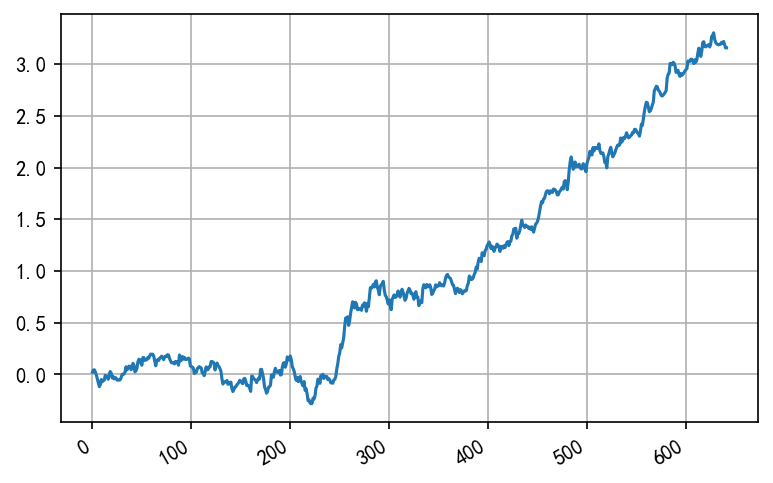

In [76]:
plt.plot(np.cumsum(np.array(pnl)))
plt.grid()
plt.gcf().autofmt_xdate()  # 自动旋转日期标记

In [69]:
%lprun -f getPnl getPnl()

20180103 首创股份 20180103.0936 价 5.35 20180104.1456 价 5.81 利润 8.6 %
20180103 北新建材 20180103.0936 价 25.25 20180104.1456 价 25.51 利润 1.03 %
20180103 山东黄金 20180103.0936 价 32.12 20180104.1456 价 31.56 利润 -1.74 %
20180103 中远海控 20180103.0936 价 6.97 20180104.1456 价 7.1 利润 1.87 %
20180104 中房股份 20180104.0936 价 11.38 20180105.1456 价 11.56 利润 1.58 %
20180104 德赛电池 20180104.0936 价 41.69 20180105.1456 价 42.05 利润 0.86 %
20180104 常熟银行 20180104.0936 价 7.41 20180105.1456 价 7.8 利润 5.26 %
20180104 中国宝安 20180104.0936 价 7.63 20180105.1456 价 7.56 利润 -0.92 %
20180104 洲际油气 20180104.0936 价 4.55 20180105.1456 价 4.61 利润 1.32 %
20180104 新潮能源 20180104.0936 价 3.98 20180105.1456 价 3.95 利润 -0.75 %
20180104 重庆钢铁 20180104.0936 价 2.37 20180105.1456 价 2.49 利润 5.06 %
20180105 赢时胜 20180105.0936 价 13.08 20180108.1456 价 13.39 利润 2.37 %
20180105 暴风退 20180105.0936 价 24.33 20180108.1456 价 25.87 利润 6.33 %
20180105 重庆啤酒 20180105.0936 价 22.65 20180108.1456 价 21.69 利润 -4.24 %
20180105 燕京啤酒 20180105.0936 价 7.12 20180108.1456 价 7.14 利润 0.28

20180213 楚江新材 20180213.0936 价 6.45 20180214.1456 价 6.39 利润 -0.93 %
20180213 用友网络 20180213.0936 价 28.81 20180214.1456 价 27.5 利润 -4.55 %
20180213 赣锋锂业 20180213.0936 价 62.8 20180214.1456 价 66.29 利润 5.56 %
20180213 杉杉股份 20180213.0936 价 17.03 20180214.1456 价 17.22 利润 1.12 %
20180213 新北洋 20180213.0936 价 14.58 20180214.1456 价 14.71 利润 0.89 %
20180214 万马股份 20180214.0936 价 7.3 20180222.1456 价 7.5 利润 2.74 %
20180214 恩捷股份 20180214.0936 价 105.3 20180222.1456 价 102.96 利润 -2.22 %
20180222 克劳斯   20180222.0936 价 10.29 20180223.1456 价 11.32 利润 10.01 %
20180222 罗 牛 山 20180222.0936 价 7.81 20180223.1456 价 7.89 利润 1.02 %
20180222 北京文化 20180222.0936 价 11.84 20180223.1456 价 11.52 利润 -2.7 %
20180222 世茂股份 20180222.0936 价 5.32 20180223.1456 价 5.29 利润 -0.56 %
20180222 成飞集成 20180222.0936 价 22.8 20180223.1456 价 22.18 利润 -2.72 %
20180222 洛阳钼业 20180222.0936 价 7.3 20180223.1456 价 8.02 利润 9.86 %
20180223 银之杰 20180223.0936 价 12.8 20180226.1456 价 14.08 利润 10.0 %
20180223 *ST当代 20180223.0936 价 13.63 20180226.1456 价 14.93

20180402 太极股份 20180402.0936 价 29.48 20180403.1456 价 30.1 利润 2.1 %
20180403 万孚生物 20180403.0936 价 67.39 20180404.1456 价 69.86 利润 3.67 %
20180403 博雅生物 20180403.0936 价 35.58 20180404.1456 价 36.53 利润 2.67 %
20180403 赤峰黄金 20180403.0936 价 7.1 20180404.1456 价 7.26 利润 2.25 %
20180404 科力远   20180404.0936 价 6.1 20180409.1456 价 5.88 利润 -3.61 %
20180404 恩华药业 20180404.0936 价 16.24 20180409.1456 价 15.98 利润 -1.6 %
20180404 人民同泰 20180404.0936 价 10.84 20180409.1456 价 10.77 利润 -0.65 %
20180404 三六零   20180404.0936 价 42.49 20180409.1456 价 40.61 利润 -4.42 %
20180404 石化机械 20180404.0936 价 10.07 20180409.1456 价 10.77 利润 6.95 %
20180404 华东医药 20180404.0936 价 70.42 20180409.1456 价 67.8 利润 -3.72 %
20180409 北斗星通 20180409.0936 价 33.06 20180410.1456 价 34.24 利润 3.57 %
20180409 锦富技术 20180409.0936 价 9.98 20180410.1456 价 9.79 利润 -1.9 %
20180410 太阳能 20180410.0936 价 5.29 20180411.1456 价 5.58 利润 5.48 %
20180410 迪马股份 20180410.0936 价 3.86 20180411.1456 价 3.89 利润 0.78 %
20180410 岳阳林纸 20180410.0936 价 6.17 20180411.1456 价 6.48 利润

20180522 珠江钢琴 20180522.0936 价 10.6 20180523.1456 价 10.39 利润 -1.98 %
20180522 拓邦股份 20180522.0936 价 10.99 20180523.1456 价 10.6 利润 -3.55 %
20180522 山大华特 20180522.0936 价 25.5 20180523.1456 价 24.95 利润 -2.16 %
20180522 *ST富控  20180522.0936 价 4.63 20180523.1456 价 4.77 利润 3.02 %
20180522 ST尤夫 20180522.0936 价 9.89 20180523.1456 价 10.38 利润 4.95 %
20180522 *ST 中绒 20180522.0936 价 2.52 20180523.1456 价 2.45 利润 -2.78 %
20180523 华贸物流 20180523.0936 价 7.91 20180524.1456 价 7.53 利润 -4.8 %
20180523 未名医药 20180523.0936 价 16.2 20180524.1456 价 15.56 利润 -3.95 %
20180523 众生药业 20180523.0936 价 12.59 20180524.1456 价 12.45 利润 -1.11 %
20180523 浙江龙盛 20180523.0936 价 13.35 20180524.1456 价 12.8 利润 -4.12 %
20180524 远 望 谷 20180524.0936 价 7.43 20180525.1456 价 8.17 利润 9.96 %
20180525 *ST信通  20180525.0936 价 3.51 20180528.1456 价 3.24 利润 -7.69 %
20180525 恒邦股份 20180525.0936 价 10.97 20180528.1456 价 10.43 利润 -4.92 %
20180525 远 望 谷 20180525.0936 价 8.17 20180528.1456 价 7.88 利润 -3.55 %
20180525 中科创达 20180525.0936 价 35.75 20180528.145

20180712 特发信息 20180712.0936 价 7.68 20180713.1456 价 7.65 利润 -0.39 %
20180713 普邦股份 20180713.0936 价 2.92 20180716.1456 价 2.8 利润 -4.11 %
20180713 吉电股份 20180713.0936 价 2.89 20180716.1456 价 2.89 利润 0.0 %
20180713 仁和药业 20180713.0936 价 7.59 20180716.1456 价 8.0 利润 5.4 %
20180713 深圳华强 20180713.0936 价 20.61 20180716.1456 价 20.39 利润 -1.07 %
20180713 荣安地产 20180713.0936 价 3.09 20180716.1456 价 2.93 利润 -5.18 %
20180713 锦富技术 20180713.0936 价 4.3 20180716.1456 价 4.66 利润 8.37 %
20180713 安洁科技 20180713.0936 价 19.18 20180716.1456 价 19.3 利润 0.63 %
20180713 聚龙股份 20180713.0936 价 10.44 20180716.1456 价 10.26 利润 -1.72 %
20180716 中兴通讯 20180716.0936 价 15.3 20180717.1456 价 17.06 利润 11.5 %
20180716 大同煤业 20180716.0936 价 4.97 20180717.1456 价 5.01 利润 0.8 %
20180716 北方国际 20180716.0936 价 7.91 20180717.1456 价 8.37 利润 5.82 %
20180716 风华高科 20180716.0936 价 23.06 20180717.1456 价 23.87 利润 3.51 %
20180716 海达股份 20180716.0936 价 5.75 20180717.1456 价 6.33 利润 10.09 %
20180717 金隅集团 20180717.0936 价 3.38 20180718.1456 价 3.39 利润 0.3 %
201

20180828 航发动力 20180828.0936 价 23.61 20180829.1456 价 23.77 利润 0.68 %
20180828 中际旭创 20180828.0936 价 53.98 20180829.1456 价 52.82 利润 -2.15 %
20180828 光启技术 20180828.0936 价 8.99 20180829.1456 价 10.32 利润 14.79 %
20180829 双鹭药业 20180829.0936 价 35.76 20180830.1456 价 34.78 利润 -2.74 %
20180829 ST尤夫 20180829.0936 价 9.73 20180830.1456 价 9.31 利润 -4.32 %
20180830 海信家电 20180830.0936 价 8.42 20180831.1456 价 8.44 利润 0.24 %
20180830 *ST天马 20180830.0936 价 1.89 20180831.1456 价 1.81 利润 -4.23 %
20180830 爱建集团 20180830.0936 价 8.94 20180831.1456 价 8.75 利润 -2.13 %
20180903 太阳能 20180903.0936 价 3.52 20180904.1456 价 3.43 利润 -2.56 %
20180903 协鑫集成 20180903.0936 价 4.95 20180904.1456 价 4.71 利润 -4.85 %
20180903 *ST信通  20180903.0936 价 2.65 20180904.1456 价 2.66 利润 0.38 %
20180903 *ST科陆 20180903.0936 价 5.85 20180904.1456 价 5.83 利润 -0.34 %
20180903 拓日新能 20180903.0936 价 3.16 20180904.1456 价 3.17 利润 0.32 %
20180904 广东甘化 20180904.0936 价 5.54 20180905.1456 价 6.13 利润 10.65 %
20180904 豫金刚石 20180904.0936 价 5.18 20180905.1456 价 5.86 

20181030 国新文化 20181030.0936 价 10.87 20181031.1456 价 11.22 利润 3.22 %
20181030 金晶科技 20181030.0936 价 2.94 20181031.1456 价 3.1 利润 5.44 %
20181031 纳思达 20181031.0936 价 24.98 20181101.1456 价 24.95 利润 -0.12 %
20181031 *ST科陆 20181031.0936 价 4.62 20181101.1456 价 4.75 利润 2.81 %
20181031 凯莱英 20181031.0936 价 62.01 20181101.1456 价 64.85 利润 4.58 %
20181031 攀钢钒钛 20181031.0936 价 4.07 20181101.1456 价 3.86 利润 -5.16 %
20181031 今世缘   20181031.0936 价 14.01 20181101.1456 价 14.85 利润 6.0 %
20181101 博实股份 20181101.0936 价 8.96 20181102.1456 价 8.8 利润 -1.79 %
20181101 *ST环球  20181101.0936 价 8.37 20181102.1456 价 8.12 利润 -2.99 %
20181101 软控股份 20181101.0936 价 5.02 20181102.1456 价 4.96 利润 -1.2 %
20181101 延华智能 20181101.0936 价 3.93 20181102.1456 价 3.87 利润 -1.53 %
20181101 珈伟新能 20181101.0936 价 5.54 20181102.1456 价 5.24 利润 -5.42 %
20181102 吉祥航空 20181102.0936 价 13.5 20181105.1456 价 13.55 利润 0.37 %
20181102 国际医学 20181102.0936 价 5.06 20181105.1456 价 5.11 利润 0.99 %
20181102 承德露露 20181102.0936 价 7.85 20181105.1456 价 7.78 利润 -0.

20181129 紫金矿业 20181129.0936 价 3.39 20181130.1456 价 3.39 利润 0.0 %
20181129 华新水泥 20181129.0936 价 18.45 20181130.1456 价 18.0 利润 -2.44 %
20181129 水井坊   20181129.0936 价 29.56 20181130.1456 价 30.07 利润 1.73 %
20181203 国泰君安 20181203.0936 价 16.87 20181204.1456 价 16.75 利润 -0.71 %
20181203 ST舍得   20181203.0936 价 23.22 20181204.1456 价 25.75 利润 10.9 %
20181203 国光电器 20181203.0936 价 5.5 20181204.1456 价 5.72 利润 4.0 %
20181204 银禧科技 20181204.0936 价 7.24 20181205.1456 价 6.61 利润 -8.7 %
20181204 聚龙股份 20181204.0936 价 8.0 20181205.1456 价 7.76 利润 -3.0 %
20181204 双林股份 20181204.0936 价 13.54 20181205.1456 价 12.19 利润 -9.97 %
20181204 蓝盾股份 20181204.0936 价 5.9 20181205.1456 价 5.98 利润 1.36 %
20181204 广东鸿图 20181204.0936 价 9.16 20181205.1456 价 8.53 利润 -6.88 %
20181204 *ST银河 20181204.0936 价 5.43 20181205.1456 价 5.14 利润 -5.34 %
20181204 晶方科技 20181204.0936 价 16.29 20181205.1456 价 16.39 利润 0.61 %
20181205 沙钢股份 20181205.0936 价 9.62 20181206.1456 价 9.67 利润 0.52 %
20181205 全新好 20181205.0936 价 8.58 20181206.1456 价 8.35 利润 -2.

20190124 *ST信通  20190124.0936 价 2.67 20190125.1456 价 2.54 利润 -4.87 %
20190124 科力远   20190124.0936 价 4.82 20190125.1456 价 4.86 利润 0.83 %
20190124 鸿达兴业 20190124.0936 价 3.78 20190125.1456 价 3.45 利润 -8.73 %
20190124 华西股份 20190124.0936 价 7.64 20190125.1456 价 7.03 利润 -7.98 %
20190124 珈伟新能 20190124.0936 价 6.66 20190125.1456 价 6.06 利润 -9.01 %
20190125 巨力索具 20190125.0936 价 3.63 20190128.1456 价 3.37 利润 -7.16 %
20190125 冀东水泥 20190125.0936 价 12.73 20190128.1456 价 12.93 利润 1.57 %
20190125 创业环保 20190125.0936 价 8.33 20190128.1456 价 7.96 利润 -4.44 %
20190125 完美世界 20190125.0936 价 26.35 20190128.1456 价 26.0 利润 -1.33 %
20190128 通策医疗 20190128.0936 价 51.68 20190129.1456 价 51.77 利润 0.17 %
20190129 恒生电子 20190129.0936 价 63.7 20190130.1456 价 62.95 利润 -1.18 %
20190131 欧菲光 20190131.0936 价 9.97 20190201.1456 价 10.38 利润 4.11 %
20190201 中信证券 20190201.0936 价 18.71 20190211.1456 价 18.85 利润 0.75 %
20190201 国泰君安 20190201.0936 价 17.11 20190211.1456 价 17.22 利润 0.64 %
20190201 鸿达兴业 20190201.0936 价 3.56 20190211.1456 价 3.7 

20190312 *ST科陆 20190312.0936 价 8.07 20190313.1456 价 7.42 利润 -8.05 %
20190312 凤凰传媒 20190312.0936 价 9.23 20190313.1456 价 9.18 利润 -0.54 %
20190312 皖维高新 20190312.0936 价 3.54 20190313.1456 价 3.42 利润 -3.39 %
20190312 拓日新能 20190312.0936 价 4.42 20190313.1456 价 4.1 利润 -7.24 %
20190313 天保基建 20190313.0936 价 4.85 20190314.1456 价 4.9 利润 1.03 %
20190313 *ST天润 20190313.0936 价 5.15 20190314.1456 价 4.38 利润 -14.95 %
20190313 *ST当代 20190313.0936 价 6.13 20190314.1456 价 5.69 利润 -7.18 %
20190313 裕同科技 20190313.0936 价 56.65 20190314.1456 价 58.5 利润 3.27 %
20190313 獐子岛 20190313.0936 价 5.53 20190314.1456 价 5.08 利润 -8.14 %
20190314 冠城大通 20190314.0936 价 4.88 20190315.1456 价 4.99 利润 2.25 %
20190314 首开股份 20190314.0936 价 9.47 20190315.1456 价 9.38 利润 -0.95 %
20190314 电子城   20190314.0936 价 7.25 20190315.1456 价 6.7 利润 -7.59 %
20190314 *ST中天  20190314.0936 价 5.14 20190315.1456 价 4.97 利润 -3.31 %
20190314 诚志股份 20190314.0936 价 18.24 20190315.1456 价 18.74 利润 2.74 %
20190314 银邦股份 20190314.0936 价 4.94 20190315.1456 价 4.81 利润 -

20190411 安迪苏   20190411.0936 价 15.15 20190412.1456 价 14.89 利润 -1.72 %
20190411 ST瑞德   20190411.0936 价 4.83 20190412.1456 价 4.6 利润 -4.76 %
20190411 *ST 中绒 20190411.0936 价 1.79 20190412.1456 价 1.9 利润 6.15 %
20190411 中粮糖业 20190411.0936 价 11.17 20190412.1456 价 10.92 利润 -2.24 %
20190411 未名医药 20190411.0936 价 11.84 20190412.1456 价 10.17 利润 -14.1 %
20190411 华峰氨纶 20190411.0936 价 6.53 20190412.1456 价 6.03 利润 -7.66 %
20190411 电子城   20190411.0936 价 7.15 20190412.1456 价 6.72 利润 -6.01 %
20190412 振东制药 20190412.0936 价 5.55 20190415.1456 价 5.21 利润 -6.13 %
20190412 *ST夏利 20190412.0936 价 7.52 20190415.1456 价 5.84 利润 -22.34 %
20190412 东方电气 20190412.0936 价 14.22 20190415.1456 价 13.96 利润 -1.83 %
20190412 远达环保 20190412.0936 价 7.75 20190415.1456 价 7.29 利润 -5.94 %
20190412 *ST 中绒 20190412.0936 价 1.88 20190415.1456 价 2.0 利润 6.38 %
20190415 穗恒运Ａ 20190415.0936 价 10.02 20190416.1456 价 10.18 利润 1.6 %
20190415 金达威 20190415.0936 价 15.93 20190416.1456 价 15.27 利润 -4.14 %
20190415 卫星石化 20190415.0936 价 18.57 20190416.145

20190516 东方日升 20190516.0936 价 11.8 20190517.1456 价 11.34 利润 -3.9 %
20190517 中科创达 20190517.0936 价 33.8 20190520.1456 价 30.07 利润 -11.04 %
20190517 新 大 陆 20190517.0936 价 17.77 20190520.1456 价 17.35 利润 -2.36 %
20190517 东方国信 20190517.0936 价 12.88 20190520.1456 价 12.37 利润 -3.96 %
20190517 国睿科技 20190517.0936 价 16.56 20190520.1456 价 16.14 利润 -2.54 %
20190517 海特高新 20190517.0936 价 12.54 20190520.1456 价 12.83 利润 2.31 %
20190520 长电科技 20190520.0936 价 12.61 20190521.1456 价 13.14 利润 4.2 %
20190520 华天科技 20190520.0936 价 5.6 20190521.1456 价 5.65 利润 0.89 %
20190520 兴森科技 20190520.0936 价 5.8 20190521.1456 价 6.26 利润 7.93 %
20190521 东方通信 20190521.0936 价 24.0 20190522.1456 价 27.25 利润 13.54 %
20190521 华谊兄弟 20190521.0936 价 5.16 20190522.1456 价 5.19 利润 0.58 %
20190521 淮河能源 20190521.0936 价 3.22 20190522.1456 价 3.11 利润 -3.42 %
20190521 金通灵 20190521.0936 价 5.41 20190522.1456 价 5.36 利润 -0.92 %
20190521 兴源环境 20190521.0936 价 4.75 20190522.1456 价 4.82 利润 1.47 %
20190522 宁波韵升 20190522.0936 价 9.9 20190523.1456 价 8.91 利润 

20190625 山东黄金 20190625.0936 价 42.3 20190626.1456 价 40.77 利润 -3.62 %
20190626 *ST猛狮 20190626.0936 价 3.01 20190627.1456 价 3.16 利润 4.98 %
20190626 南京新百 20190626.0936 价 11.37 20190627.1456 价 11.42 利润 0.44 %
20190626 ST摩登 20190626.0936 价 5.56 20190627.1456 价 5.6 利润 0.72 %
20190626 成飞集成 20190626.0936 价 18.21 20190627.1456 价 18.2 利润 -0.05 %
20190626 ST康美   20190626.0936 价 3.13 20190627.1456 价 3.3 利润 5.43 %
20190627 杰赛科技 20190627.0936 价 13.01 20190628.1456 价 13.0 利润 -0.08 %
20190627 深南电路 20190627.0936 价 99.58 20190628.1456 价 102.2 利润 2.63 %
20190627 *ST晨鑫 20190627.0936 价 4.01 20190628.1456 价 3.4 利润 -15.21 %
20190627 生益科技 20190627.0936 价 15.07 20190628.1456 价 15.01 利润 -0.4 %
20190627 兴森科技 20190627.0936 价 6.44 20190628.1456 价 6.56 利润 1.86 %
20190628 滨化股份 20190628.0936 价 6.82 20190701.1456 价 6.98 利润 2.35 %
20190628 合众思壮 20190628.0936 价 12.3 20190701.1456 价 11.44 利润 -6.99 %
20190628 深南电路 20190628.0936 价 102.42 20190701.1456 价 107.71 利润 5.17 %
20190628 梦网集团 20190628.0936 价 15.99 20190701.1456 价 14.

20190814 京运通   20190814.0936 价 3.2 20190815.1456 价 3.16 利润 -1.25 %
20190815 *ST金洲 20190815.0936 价 2.62 20190816.1456 价 2.5 利润 -4.58 %
20190815 山东黄金 20190815.0936 价 50.52 20190816.1456 价 51.23 利润 1.41 %
20190815 恒邦股份 20190815.0936 价 18.42 20190816.1456 价 17.9 利润 -2.82 %
20190815 湖南黄金 20190815.0936 价 9.94 20190816.1456 价 9.74 利润 -2.01 %
20190815 赤峰黄金 20190815.0936 价 5.99 20190816.1456 价 5.83 利润 -2.67 %
20190815 中金黄金 20190815.0936 价 10.32 20190816.1456 价 10.07 利润 -2.42 %
20190816 中国船舶 20190816.0936 价 24.85 20190819.1456 价 23.82 利润 -4.14 %
20190816 明泰铝业 20190816.0936 价 10.07 20190819.1456 价 10.33 利润 2.58 %
20190816 亿纬锂能 20190816.0936 价 33.04 20190819.1456 价 34.19 利润 3.48 %
20190816 *ST金鸿 20190816.0936 价 4.25 20190819.1456 价 4.19 利润 -1.41 %
20190816 瀚蓝环境 20190816.0936 价 17.17 20190819.1456 价 18.01 利润 4.89 %
20190816 东吴证券 20190816.0936 价 9.19 20190819.1456 价 9.64 利润 4.9 %
20190819 华联控股 20190819.0936 价 4.87 20190820.1456 价 4.65 利润 -4.52 %
20190819 *ST信通  20190819.0936 价 2.43 20190820.1456 价 2

20190925 京基智农 20190925.0936 价 24.54 20190926.1456 价 24.87 利润 1.34 %
20190926 *ST沈机 20190926.0936 价 7.48 20190927.1456 价 6.61 利润 -11.63 %
20190926 南极电商 20190926.0936 价 10.8 20190927.1456 价 10.67 利润 -1.2 %
20190926 财通证券 20190926.0936 价 10.83 20190927.1456 价 10.39 利润 -4.06 %
20190926 ST海马 20190926.0936 价 1.9 20190927.1456 价 1.91 利润 0.53 %
20190927 开山股份 20190927.0936 价 10.73 20190930.1456 价 10.96 利润 2.14 %
20190930 东方锆业 20190930.0936 价 6.75 20191008.1456 价 6.54 利润 -3.11 %
20190930 *ST华映 20190930.0936 价 2.76 20191008.1456 价 2.69 利润 -2.54 %
20190930 中国石油 20190930.0936 价 6.18 20191008.1456 价 6.12 利润 -0.97 %
20190930 ST游久   20190930.0936 价 2.04 20191008.1456 价 2.04 利润 0.0 %
20191008 *ST猛狮 20191008.0936 价 2.93 20191009.1456 价 2.82 利润 -3.75 %
20191008 *ST 中绒 20191008.0936 价 1.66 20191009.1456 价 1.62 利润 -2.41 %
20191009 兰生股份 20191009.0936 价 12.54 20191010.1456 价 12.7 利润 1.28 %
20191009 浔兴股份 20191009.0936 价 6.91 20191010.1456 价 7.24 利润 4.78 %
20191009 光启技术 20191009.0936 价 9.25 20191010.1456 价 9.53

20191125 新钢股份 20191125.0936 价 4.91 20191126.1456 价 4.86 利润 -1.02 %
20191125 南钢股份 20191125.0936 价 3.4 20191126.1456 价 3.34 利润 -1.76 %
20191125 ST中孚   20191125.0936 价 2.0 20191126.1456 价 2.14 利润 7.0 %
20191125 宝钢股份 20191125.0936 价 5.62 20191126.1456 价 5.68 利润 1.07 %
20191125 鹿港文化 20191125.0936 价 3.5 20191126.1456 价 3.85 利润 10.0 %
20191126 中国船舶 20191126.0936 价 20.61 20191127.1456 价 20.36 利润 -1.21 %
20191126 宜通世纪 20191126.0936 价 5.39 20191127.1456 价 5.09 利润 -5.57 %
20191126 ST中孚   20191126.0936 价 2.14 20191127.1456 价 2.14 利润 0.0 %
20191126 中国重工 20191126.0936 价 5.37 20191127.1456 价 5.33 利润 -0.74 %
20191126 广日股份 20191126.0936 价 7.39 20191127.1456 价 7.06 利润 -4.47 %
20191126 新华传媒 20191126.0936 价 5.25 20191127.1456 价 5.29 利润 0.76 %
20191126 世纪华通 20191126.0936 价 9.78 20191127.1456 价 10.0 利润 2.25 %
20191127 *ST 中绒 20191127.0936 价 2.06 20191128.1456 价 2.12 利润 2.91 %
20191127 罗 牛 山 20191127.0936 价 9.32 20191128.1456 价 9.14 利润 -1.93 %
20191127 *ST新光 20191127.0936 价 2.08 20191128.1456 价 2.01 利润 -3.37

20200107 *ST信通  20200107.0936 价 3.73 20200108.1456 价 3.69 利润 -1.07 %
20200107 东方日升 20200107.0936 价 15.5 20200108.1456 价 17.05 利润 10.0 %
20200107 晶方科技 20200107.0936 价 55.51 20200108.1456 价 49.96 利润 -10.0 %
20200107 云南锗业 20200107.0936 价 11.6 20200108.1456 价 11.66 利润 0.52 %
20200108 大北农 20200108.0936 价 8.02 20200109.1456 价 7.55 利润 -5.86 %
20200108 捷成股份 20200108.0936 价 4.45 20200109.1456 价 4.48 利润 0.67 %
20200108 西藏城投 20200108.0936 价 6.11 20200109.1456 价 6.49 利润 6.22 %
20200108 赤峰黄金 20200108.0936 价 6.35 20200109.1456 价 5.96 利润 -6.14 %
20200108 石化油服 20200108.0936 价 2.48 20200109.1456 价 2.39 利润 -3.63 %
20200109 ST庞大   20200109.0936 价 1.61 20200110.1456 价 1.53 利润 -4.97 %
20200109 华安证券 20200109.0936 价 7.63 20200110.1456 价 7.34 利润 -3.8 %
20200109 *ST新光 20200109.0936 价 2.43 20200110.1456 价 2.41 利润 -0.82 %
20200109 银邦股份 20200109.0936 价 3.85 20200110.1456 价 3.4 利润 -11.69 %
20200110 青岛金王 20200110.0936 价 5.56 20200113.1456 价 5.47 利润 -1.62 %
20200110 博彦科技 20200110.0936 价 11.13 20200113.1456 价 10.67 利

20200226 中国船舶 20200226.0936 价 21.18 20200227.1456 价 20.61 利润 -2.69 %
20200226 新日恒力 20200226.0936 价 4.65 20200227.1456 价 4.71 利润 1.29 %
20200226 银禧科技 20200226.0936 价 6.76 20200227.1456 价 6.0 利润 -11.24 %
20200226 佛塑科技 20200226.0936 价 6.48 20200227.1456 价 6.11 利润 -5.71 %
20200226 四环生物 20200226.0936 价 6.5 20200227.1456 价 5.9 利润 -9.23 %
20200226 南  玻Ａ 20200226.0936 价 6.46 20200227.1456 价 5.56 利润 -13.93 %
20200226 得润电子 20200226.0936 价 17.57 20200227.1456 价 19.01 利润 8.2 %
20200226 天威视讯 20200226.0936 价 9.5 20200227.1456 价 8.87 利润 -6.63 %
20200227 先导智能 20200227.0936 价 60.19 20200228.1456 价 55.99 利润 -6.98 %
20200227 *ST猛狮 20200227.0936 价 5.41 20200228.1456 价 5.68 利润 4.99 %
20200302 富奥股份 20200302.0936 价 6.41 20200303.1456 价 6.6 利润 2.96 %
20200302 汉钟精机 20200302.0936 价 14.69 20200303.1456 价 16.16 利润 10.01 %
20200302 东方园林 20200302.0936 价 5.14 20200303.1456 价 5.65 利润 9.92 %
20200302 中炬高新 20200302.0936 价 39.66 20200303.1456 价 41.32 利润 4.19 %
20200303 津滨发展 20200303.0936 价 2.52 20200304.1456 价 2.65 利润 5

20200414 盈峰环境 20200414.0936 价 6.1 20200415.1456 价 6.08 利润 -0.33 %
20200414 宝信软件 20200414.0936 价 43.9 20200415.1456 价 45.35 利润 3.3 %
20200414 博实股份 20200414.0936 价 9.72 20200415.1456 价 9.54 利润 -1.85 %
20200415 苏宁环球 20200415.0936 价 3.13 20200416.1456 价 3.16 利润 0.96 %
20200415 省广集团 20200415.0936 价 4.33 20200416.1456 价 4.76 利润 9.93 %
20200415 达安基因 20200415.0936 价 19.67 20200416.1456 价 22.53 利润 14.54 %
20200415 曙光股份 20200415.0936 价 4.39 20200416.1456 价 4.03 利润 -8.2 %
20200415 吉电股份 20200415.0936 价 3.84 20200416.1456 价 3.94 利润 2.6 %
20200415 三花智控 20200415.0936 价 19.24 20200416.1456 价 19.23 利润 -0.05 %
20200415 *ST德豪 20200415.0936 价 1.78 20200416.1456 价 1.71 利润 -3.93 %
20200415 大洋电机 20200415.0936 价 3.44 20200416.1456 价 3.65 利润 6.1 %
20200416 多氟多 20200416.0936 价 11.55 20200417.1456 价 11.25 利润 -2.6 %
20200416 省广集团 20200416.0936 价 4.76 20200417.1456 价 4.41 利润 -7.35 %
20200416 ST新海 20200416.0936 价 2.78 20200417.1456 价 2.92 利润 5.04 %
20200416 以岭药业 20200416.0936 价 37.9 20200417.1456 价 35.16 利润 -7.23 %

20200522 *ST银河 20200522.0936 价 1.19 20200525.1456 价 1.25 利润 5.04 %
20200525 *ST兆新 20200525.0936 价 0.81 20200526.1456 价 0.85 利润 4.94 %
20200525 ST网力 20200525.0936 价 3.29 20200526.1456 价 3.62 利润 10.03 %
20200525 焦作万方 20200525.0936 价 4.79 20200526.1456 价 5.27 利润 10.02 %
20200525 众应互联 20200525.0936 价 6.2 20200526.1456 价 6.24 利润 0.65 %
20200525 王府井   20200525.0936 价 20.1 20200526.1456 价 20.27 利润 0.85 %
20200525 *ST银河 20200525.0936 价 1.25 20200526.1456 价 1.31 利润 4.8 %
20200525 *ST德豪 20200525.0936 价 1.41 20200526.1456 价 1.48 利润 4.96 %
20200525 *ST晨鑫 20200525.0936 价 1.07 20200526.1456 价 1.12 利润 4.67 %
20200526 蓝帆医疗 20200526.0936 价 19.65 20200527.1456 价 21.62 利润 10.03 %
20200526 *ST金洲 20200526.0936 价 0.7 20200527.1456 价 0.74 利润 5.71 %
20200526 ST新海 20200526.0936 价 2.17 20200527.1456 价 2.28 利润 5.07 %
20200527 高新兴 20200527.0936 价 5.62 20200528.1456 价 5.4 利润 -3.91 %
20200527 江淮汽车 20200527.0936 价 7.41 20200528.1456 价 8.38 利润 13.09 %
20200527 中南传媒 20200527.0936 价 11.08 20200528.1456 价 10.67 利润 -3.7 

20200702 阳 光 城 20200702.0936 价 7.23 20200703.1456 价 7.46 利润 3.18 %
20200702 金科股份 20200702.0936 价 9.49 20200703.1456 价 9.13 利润 -3.79 %
20200702 普洛药业 20200702.0936 价 24.44 20200703.1456 价 24.73 利润 1.19 %
20200702 北新建材 20200702.0936 价 23.15 20200703.1456 价 24.12 利润 4.19 %
20200703 国金证券 20200703.0936 价 13.75 20200706.1456 价 15.35 利润 11.64 %
20200703 紫光国微 20200703.0936 价 93.46 20200706.1456 价 106.51 利润 13.96 %
20200703 浙富控股 20200703.0936 价 4.11 20200706.1456 价 4.64 利润 12.9 %
20200703 泰禾集团 20200703.0936 价 6.07 20200706.1456 价 7.0 利润 15.32 %
20200703 三友化工 20200703.0936 价 4.94 20200706.1456 价 5.31 利润 7.49 %
20200703 中国电建 20200703.0936 价 3.78 20200706.1456 价 4.15 利润 9.79 %
20200703 哈投股份 20200703.0936 价 6.78 20200706.1456 价 8.01 利润 18.14 %
20200706 精锻科技 20200706.0936 价 13.13 20200707.1456 价 12.91 利润 -1.68 %
20200706 国网英大 20200706.0936 价 7.9 20200707.1456 价 8.09 利润 2.41 %
20200706 吉林敖东 20200706.0936 价 18.13 20200707.1456 价 18.35 利润 1.21 %
20200706 中信证券 20200706.0936 价 30.2 20200707.1456 价 31.06 利

20200812 天齐锂业 20200812.0936 价 26.59 20200813.1456 价 26.89 利润 1.13 %
20200812 东北制药 20200812.0936 价 6.02 20200813.1456 价 6.11 利润 1.5 %
20200812 *ST华映 20200812.0936 价 1.92 20200813.1456 价 2.03 利润 5.73 %
20200813 黑牡丹   20200813.0936 价 9.9 20200814.1456 价 9.3 利润 -6.06 %
20200813 协鑫集成 20200813.0936 价 5.67 20200814.1456 价 5.16 利润 -8.99 %
20200813 晋亿实业 20200813.0936 价 6.55 20200814.1456 价 6.33 利润 -3.36 %
20200813 福田汽车 20200813.0936 价 2.95 20200814.1456 价 3.16 利润 7.12 %
20200813 盾安环境 20200813.0936 价 4.16 20200814.1456 价 4.04 利润 -2.88 %
20200813 一汽富维 20200813.0936 价 12.0 20200814.1456 价 11.92 利润 -0.67 %
20200814 协鑫集成 20200814.0936 价 6.23 20200817.1456 价 5.68 利润 -8.83 %
20200814 *ST梦舟  20200814.0936 价 1.4 20200817.1456 价 1.47 利润 5.0 %
20200814 中鼎股份 20200814.0936 价 11.4 20200817.1456 价 12.45 利润 9.21 %
20200814 瀚蓝环境 20200814.0936 价 27.39 20200817.1456 价 28.74 利润 4.93 %
20200817 航天科技 20200817.0936 价 13.2 20200818.1456 价 13.34 利润 1.06 %
20200817 柳钢股份 20200817.0936 价 4.98 20200818.1456 价 5.07 利润 1.81 